## Generation of Make-Moons dataset

Using device: cuda


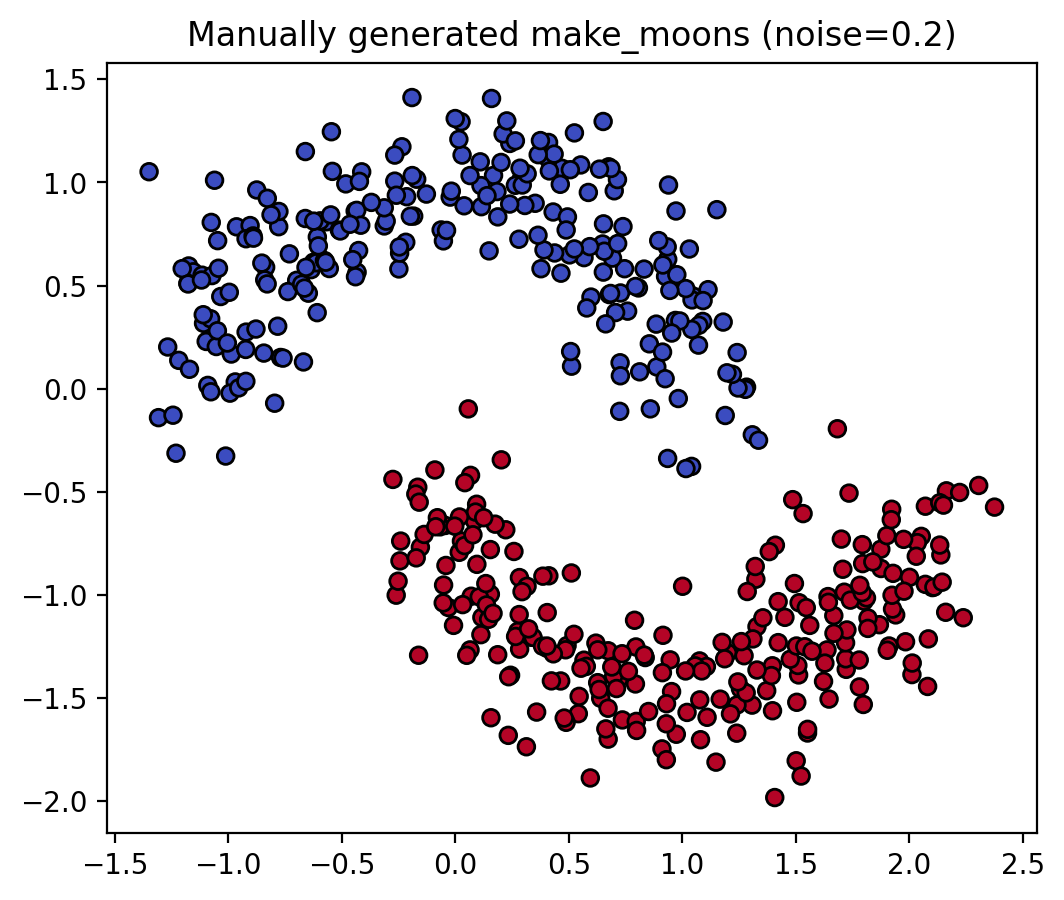

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

import seaborn as sns
from mlxtend.plotting import plot_decision_regions

import os
import re
import kagglehub
from sklearn.metrics import roc_auc_score

# Cuda using
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Hyperparameters
input_dim = 2
hidden1_dim = 10
hidden2_dim = 10
output_dim = 2



def generate_moons(n_samples=500, noise=0.2, seed=1337):
    np.random.seed(seed)
    
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out

    # Upper semicircle
    theta = np.linspace(0, np.pi, n_samples_out)
    x_outer = np.cos(theta)
    y_outer = np.sin(theta)
    outer = np.stack([x_outer, y_outer], axis=1)
    
    # Lower semicircle (shifted)
    theta = np.linspace(0, np.pi, n_samples_in)
    x_inner = 1 - np.cos(theta)
    y_inner = -np.sin(theta) - 0.5
    inner = np.stack([x_inner, y_inner], axis=1)
    
    X = np.vstack([outer, inner])
    y = np.hstack([np.zeros(n_samples_out), np.ones(n_samples_in)])

    X += np.random.normal(scale=noise, size=X.shape)
    
    return X, y

X, y = generate_moons(n_samples=500, noise=0.2)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("Manually generated make_moons (noise=0.2)")
plt.show()


## Defining datasets

In [91]:
X_train, y_train = generate_moons(500, noise=0.2, seed=1337)

X_test_01, y_test_01 = generate_moons(500, noise=0.1, seed=1337)
X_test_02, y_test_02 = generate_moons(500, noise=0.2, seed=1337)
X_test_03, y_test_03 = generate_moons(500, noise=0.3, seed=1337)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1337, stratify=y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test_01 = scaler.transform(X_test_01)
X_test_02 = scaler.transform(X_test_02)
X_test_03 = scaler.transform(X_test_03)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test_02.shape}")

Train shape: (400, 2), Val shape: (100, 2), Test shape: (500, 2)


## MLP Architecture

In [92]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.fc3 = nn.Linear(hidden2_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))    # Hidden layer with ReLU activation
        x = F.relu(self.fc2(x))    # Hidden layer with ReLU activation
        x = self.fc3(x)            # Output layer (raw logits)
        return x

## MLP with hidden layer - early stopping (patience=50)

In [93]:
def MLP__early_stopping(model, device, X_train, y_train, X_val, y_val, lr=1e-3, epochs=1000, patience=50):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # store loss history
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        loss = loss_fn(logits, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            val_loss = loss_fn(val_logits, y_val)

        # record losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # early stopping check
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}, best val loss = {best_val_loss:.4f}")
            break
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

    # Load best model
    model.load_state_dict(best_model_state)

    return model, train_losses, val_losses


In [94]:
model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
trained_MLP, train_loss, val_loss = MLP__early_stopping(model, device, X_train, y_train, X_val, y_val)

Epoch 0 | Train Loss: 0.7342 | Val Loss: 0.7332
Epoch 50 | Train Loss: 0.6230 | Val Loss: 0.6227
Epoch 100 | Train Loss: 0.4568 | Val Loss: 0.4543
Epoch 150 | Train Loss: 0.2567 | Val Loss: 0.2544
Epoch 200 | Train Loss: 0.1314 | Val Loss: 0.1340
Epoch 250 | Train Loss: 0.0758 | Val Loss: 0.0818
Epoch 300 | Train Loss: 0.0510 | Val Loss: 0.0587
Epoch 350 | Train Loss: 0.0383 | Val Loss: 0.0466
Epoch 400 | Train Loss: 0.0305 | Val Loss: 0.0392
Epoch 450 | Train Loss: 0.0259 | Val Loss: 0.0354
Epoch 500 | Train Loss: 0.0227 | Val Loss: 0.0324
Epoch 550 | Train Loss: 0.0203 | Val Loss: 0.0305
Epoch 600 | Train Loss: 0.0183 | Val Loss: 0.0291
Epoch 650 | Train Loss: 0.0164 | Val Loss: 0.0286
Early stopping at epoch 673, best val loss = 0.0286


In [95]:
model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
trained_MLP_01, train_loss_01, val_loss_01 = MLP__early_stopping(model, device, X_train, y_train, X_test_01, y_test_01)

Epoch 0 | Train Loss: 0.7309 | Val Loss: 0.7287
Epoch 50 | Train Loss: 0.6251 | Val Loss: 0.6214
Epoch 100 | Train Loss: 0.5030 | Val Loss: 0.4949
Epoch 150 | Train Loss: 0.3602 | Val Loss: 0.3475
Epoch 200 | Train Loss: 0.2327 | Val Loss: 0.2174
Epoch 250 | Train Loss: 0.1419 | Val Loss: 0.1258
Epoch 300 | Train Loss: 0.0924 | Val Loss: 0.0766
Epoch 350 | Train Loss: 0.0633 | Val Loss: 0.0477
Epoch 400 | Train Loss: 0.0475 | Val Loss: 0.0325
Epoch 450 | Train Loss: 0.0389 | Val Loss: 0.0242
Epoch 500 | Train Loss: 0.0332 | Val Loss: 0.0190
Epoch 550 | Train Loss: 0.0291 | Val Loss: 0.0153
Epoch 600 | Train Loss: 0.0260 | Val Loss: 0.0127
Epoch 650 | Train Loss: 0.0237 | Val Loss: 0.0108
Epoch 700 | Train Loss: 0.0218 | Val Loss: 0.0094
Epoch 750 | Train Loss: 0.0201 | Val Loss: 0.0082
Epoch 800 | Train Loss: 0.0188 | Val Loss: 0.0072
Epoch 850 | Train Loss: 0.0176 | Val Loss: 0.0065
Epoch 900 | Train Loss: 0.0166 | Val Loss: 0.0058
Epoch 950 | Train Loss: 0.0156 | Val Loss: 0.0052


In [96]:
model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
trained_MLP_02, train_loss_02, val_loss_02 = MLP__early_stopping(model, device, X_train, y_train, X_test_02, y_test_02)

Epoch 0 | Train Loss: 0.6943 | Val Loss: 0.6913
Epoch 50 | Train Loss: 0.5507 | Val Loss: 0.5464
Epoch 100 | Train Loss: 0.3409 | Val Loss: 0.3353
Epoch 150 | Train Loss: 0.1707 | Val Loss: 0.1677
Epoch 200 | Train Loss: 0.0934 | Val Loss: 0.0928
Epoch 250 | Train Loss: 0.0616 | Val Loss: 0.0619
Epoch 300 | Train Loss: 0.0461 | Val Loss: 0.0470
Epoch 350 | Train Loss: 0.0374 | Val Loss: 0.0387
Epoch 400 | Train Loss: 0.0319 | Val Loss: 0.0335
Epoch 450 | Train Loss: 0.0280 | Val Loss: 0.0298
Epoch 500 | Train Loss: 0.0249 | Val Loss: 0.0270
Epoch 550 | Train Loss: 0.0223 | Val Loss: 0.0248
Epoch 600 | Train Loss: 0.0201 | Val Loss: 0.0229
Epoch 650 | Train Loss: 0.0182 | Val Loss: 0.0212
Epoch 700 | Train Loss: 0.0164 | Val Loss: 0.0197
Epoch 750 | Train Loss: 0.0149 | Val Loss: 0.0184
Epoch 800 | Train Loss: 0.0137 | Val Loss: 0.0173
Epoch 850 | Train Loss: 0.0126 | Val Loss: 0.0164
Epoch 900 | Train Loss: 0.0116 | Val Loss: 0.0155
Epoch 950 | Train Loss: 0.0107 | Val Loss: 0.0147


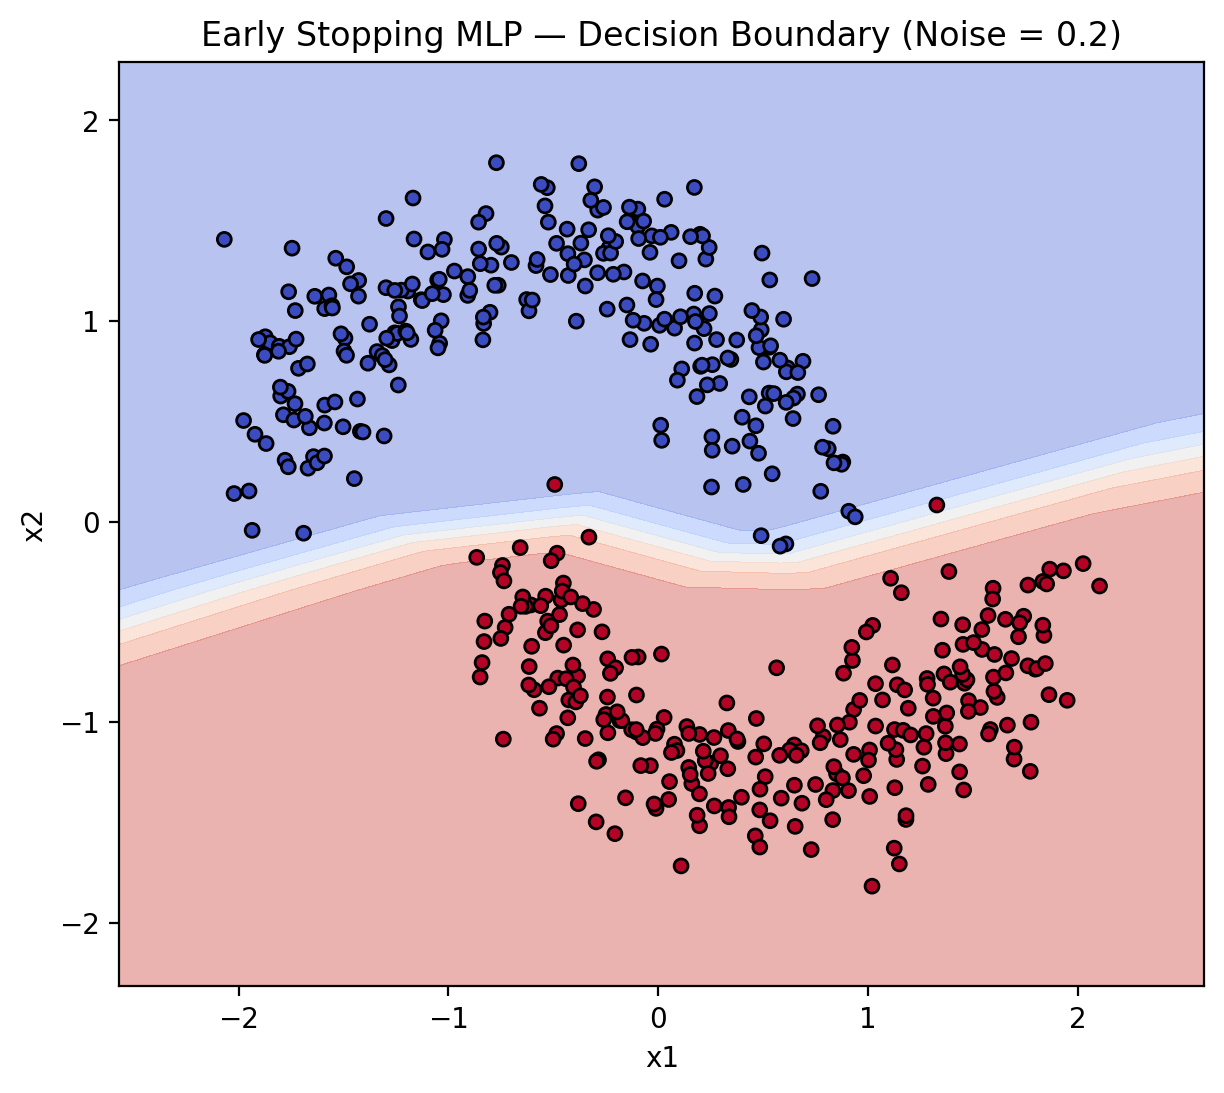

In [97]:
def plot_decision_boundary_torch(model, X, y, title):
    import numpy as np
    import matplotlib.pyplot as plt
    import torch

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]

    model.eval()
    with torch.no_grad():
        grid_t = torch.tensor(grid, dtype=torch.float32).to(next(model.parameters()).device)
        logits = model(grid_t)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

    Z = probs.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=25, edgecolors='k')

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")

plt.figure(figsize=(7, 6))
plot_decision_boundary_torch(
    trained_MLP_02,
    X_test_02,
    y_test_02,
    title="Early Stopping MLP — Decision Boundary (Noise = 0.2)"
)
plt.show()


In [98]:
model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
trained_MLP_03, train_loss_03, val_loss_03 = MLP__early_stopping(model, device, X_train, y_train, X_test_03, y_test_03)

Epoch 0 | Train Loss: 0.6558 | Val Loss: 0.6564
Epoch 50 | Train Loss: 0.5534 | Val Loss: 0.5532
Epoch 100 | Train Loss: 0.3942 | Val Loss: 0.3950
Epoch 150 | Train Loss: 0.2410 | Val Loss: 0.2494
Epoch 200 | Train Loss: 0.1490 | Val Loss: 0.1656
Epoch 250 | Train Loss: 0.1003 | Val Loss: 0.1218
Epoch 300 | Train Loss: 0.0730 | Val Loss: 0.0980
Epoch 350 | Train Loss: 0.0568 | Val Loss: 0.0843
Epoch 400 | Train Loss: 0.0465 | Val Loss: 0.0759
Epoch 450 | Train Loss: 0.0395 | Val Loss: 0.0705
Epoch 500 | Train Loss: 0.0343 | Val Loss: 0.0669
Epoch 550 | Train Loss: 0.0304 | Val Loss: 0.0645
Epoch 600 | Train Loss: 0.0274 | Val Loss: 0.0629
Epoch 650 | Train Loss: 0.0248 | Val Loss: 0.0614
Epoch 700 | Train Loss: 0.0227 | Val Loss: 0.0600
Epoch 750 | Train Loss: 0.0208 | Val Loss: 0.0588
Epoch 800 | Train Loss: 0.0191 | Val Loss: 0.0577
Epoch 850 | Train Loss: 0.0175 | Val Loss: 0.0567
Epoch 900 | Train Loss: 0.0161 | Val Loss: 0.0557
Epoch 950 | Train Loss: 0.0150 | Val Loss: 0.0551


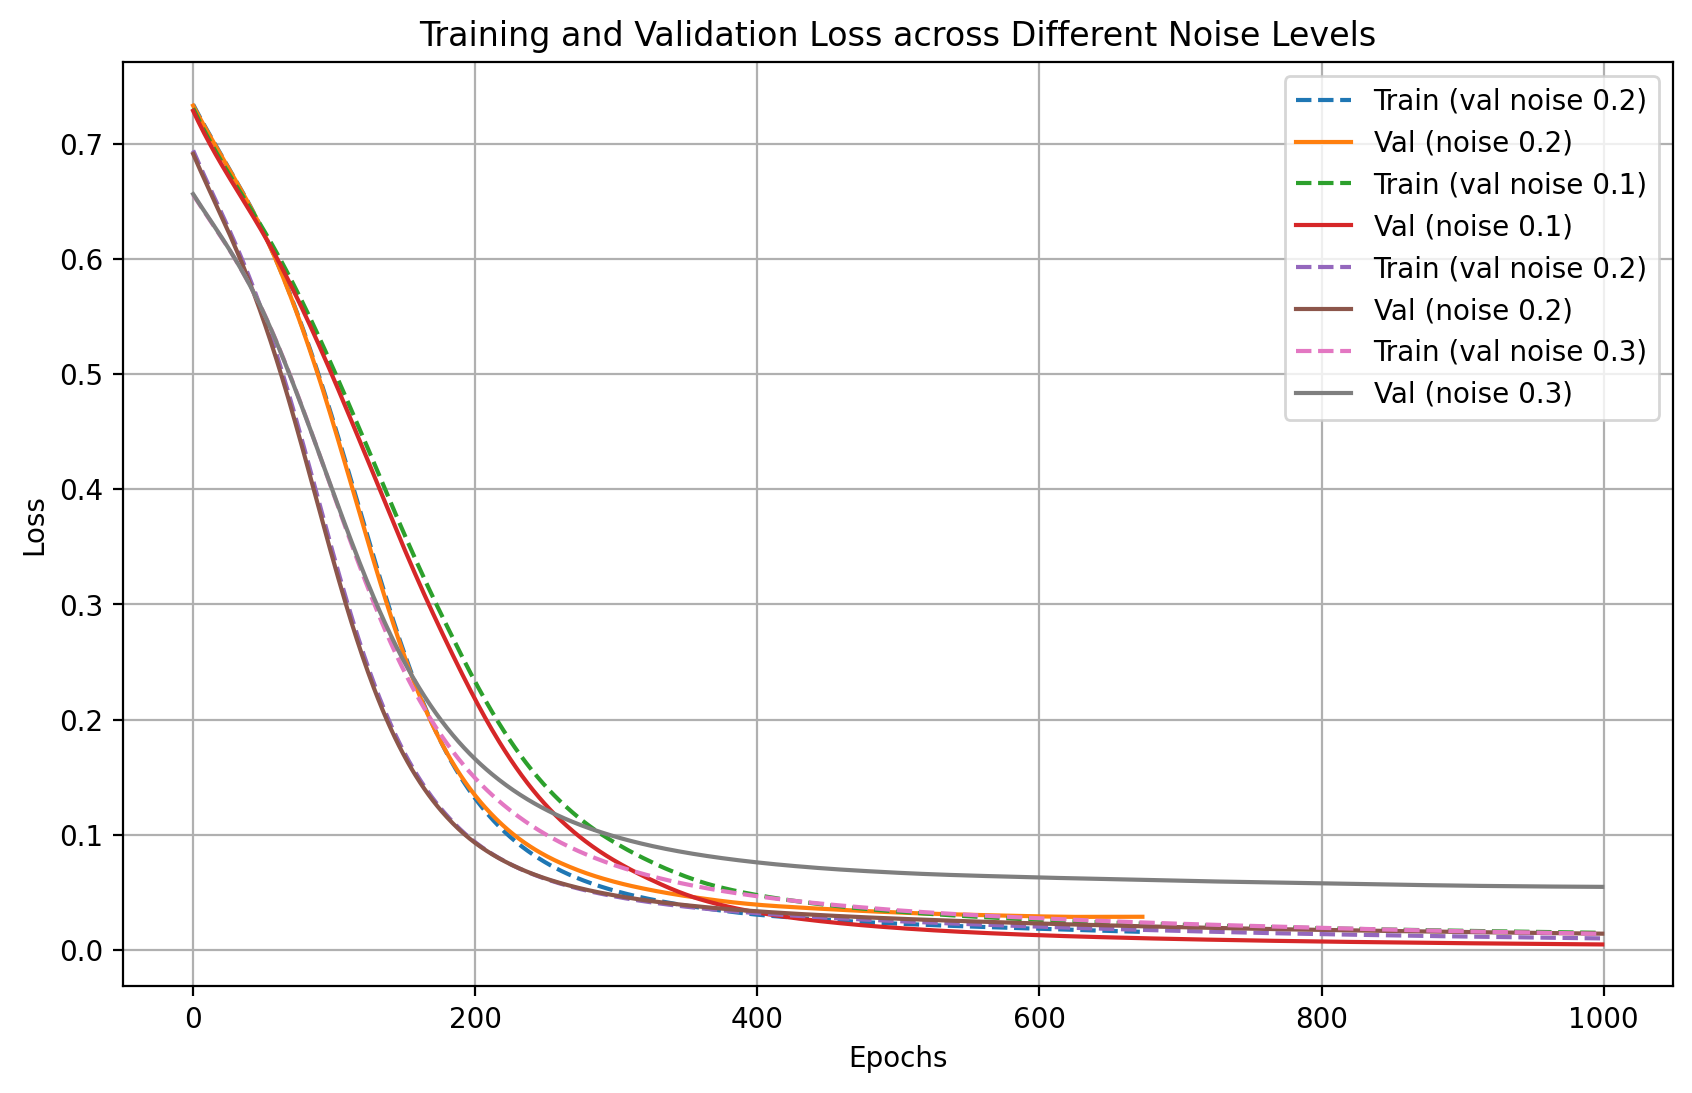

In [99]:
plt.figure(figsize=(10, 6))

# Plot each dataset
plt.plot(train_loss, label="Train (val noise 0.2)", linestyle='--')
plt.plot(val_loss, label="Val (noise 0.2)")
plt.plot(train_loss_01, label="Train (val noise 0.1)", linestyle='--')
plt.plot(val_loss_01, label="Val (noise 0.1)")
plt.plot(train_loss_02, label="Train (val noise 0.2)", linestyle='--')
plt.plot(val_loss_02, label="Val (noise 0.2)")
plt.plot(train_loss_03, label="Train (val noise 0.3)", linestyle='--')
plt.plot(val_loss_03, label="Val (noise 0.3)")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss across Different Noise Levels")
plt.legend()
plt.grid(True)
plt.show()

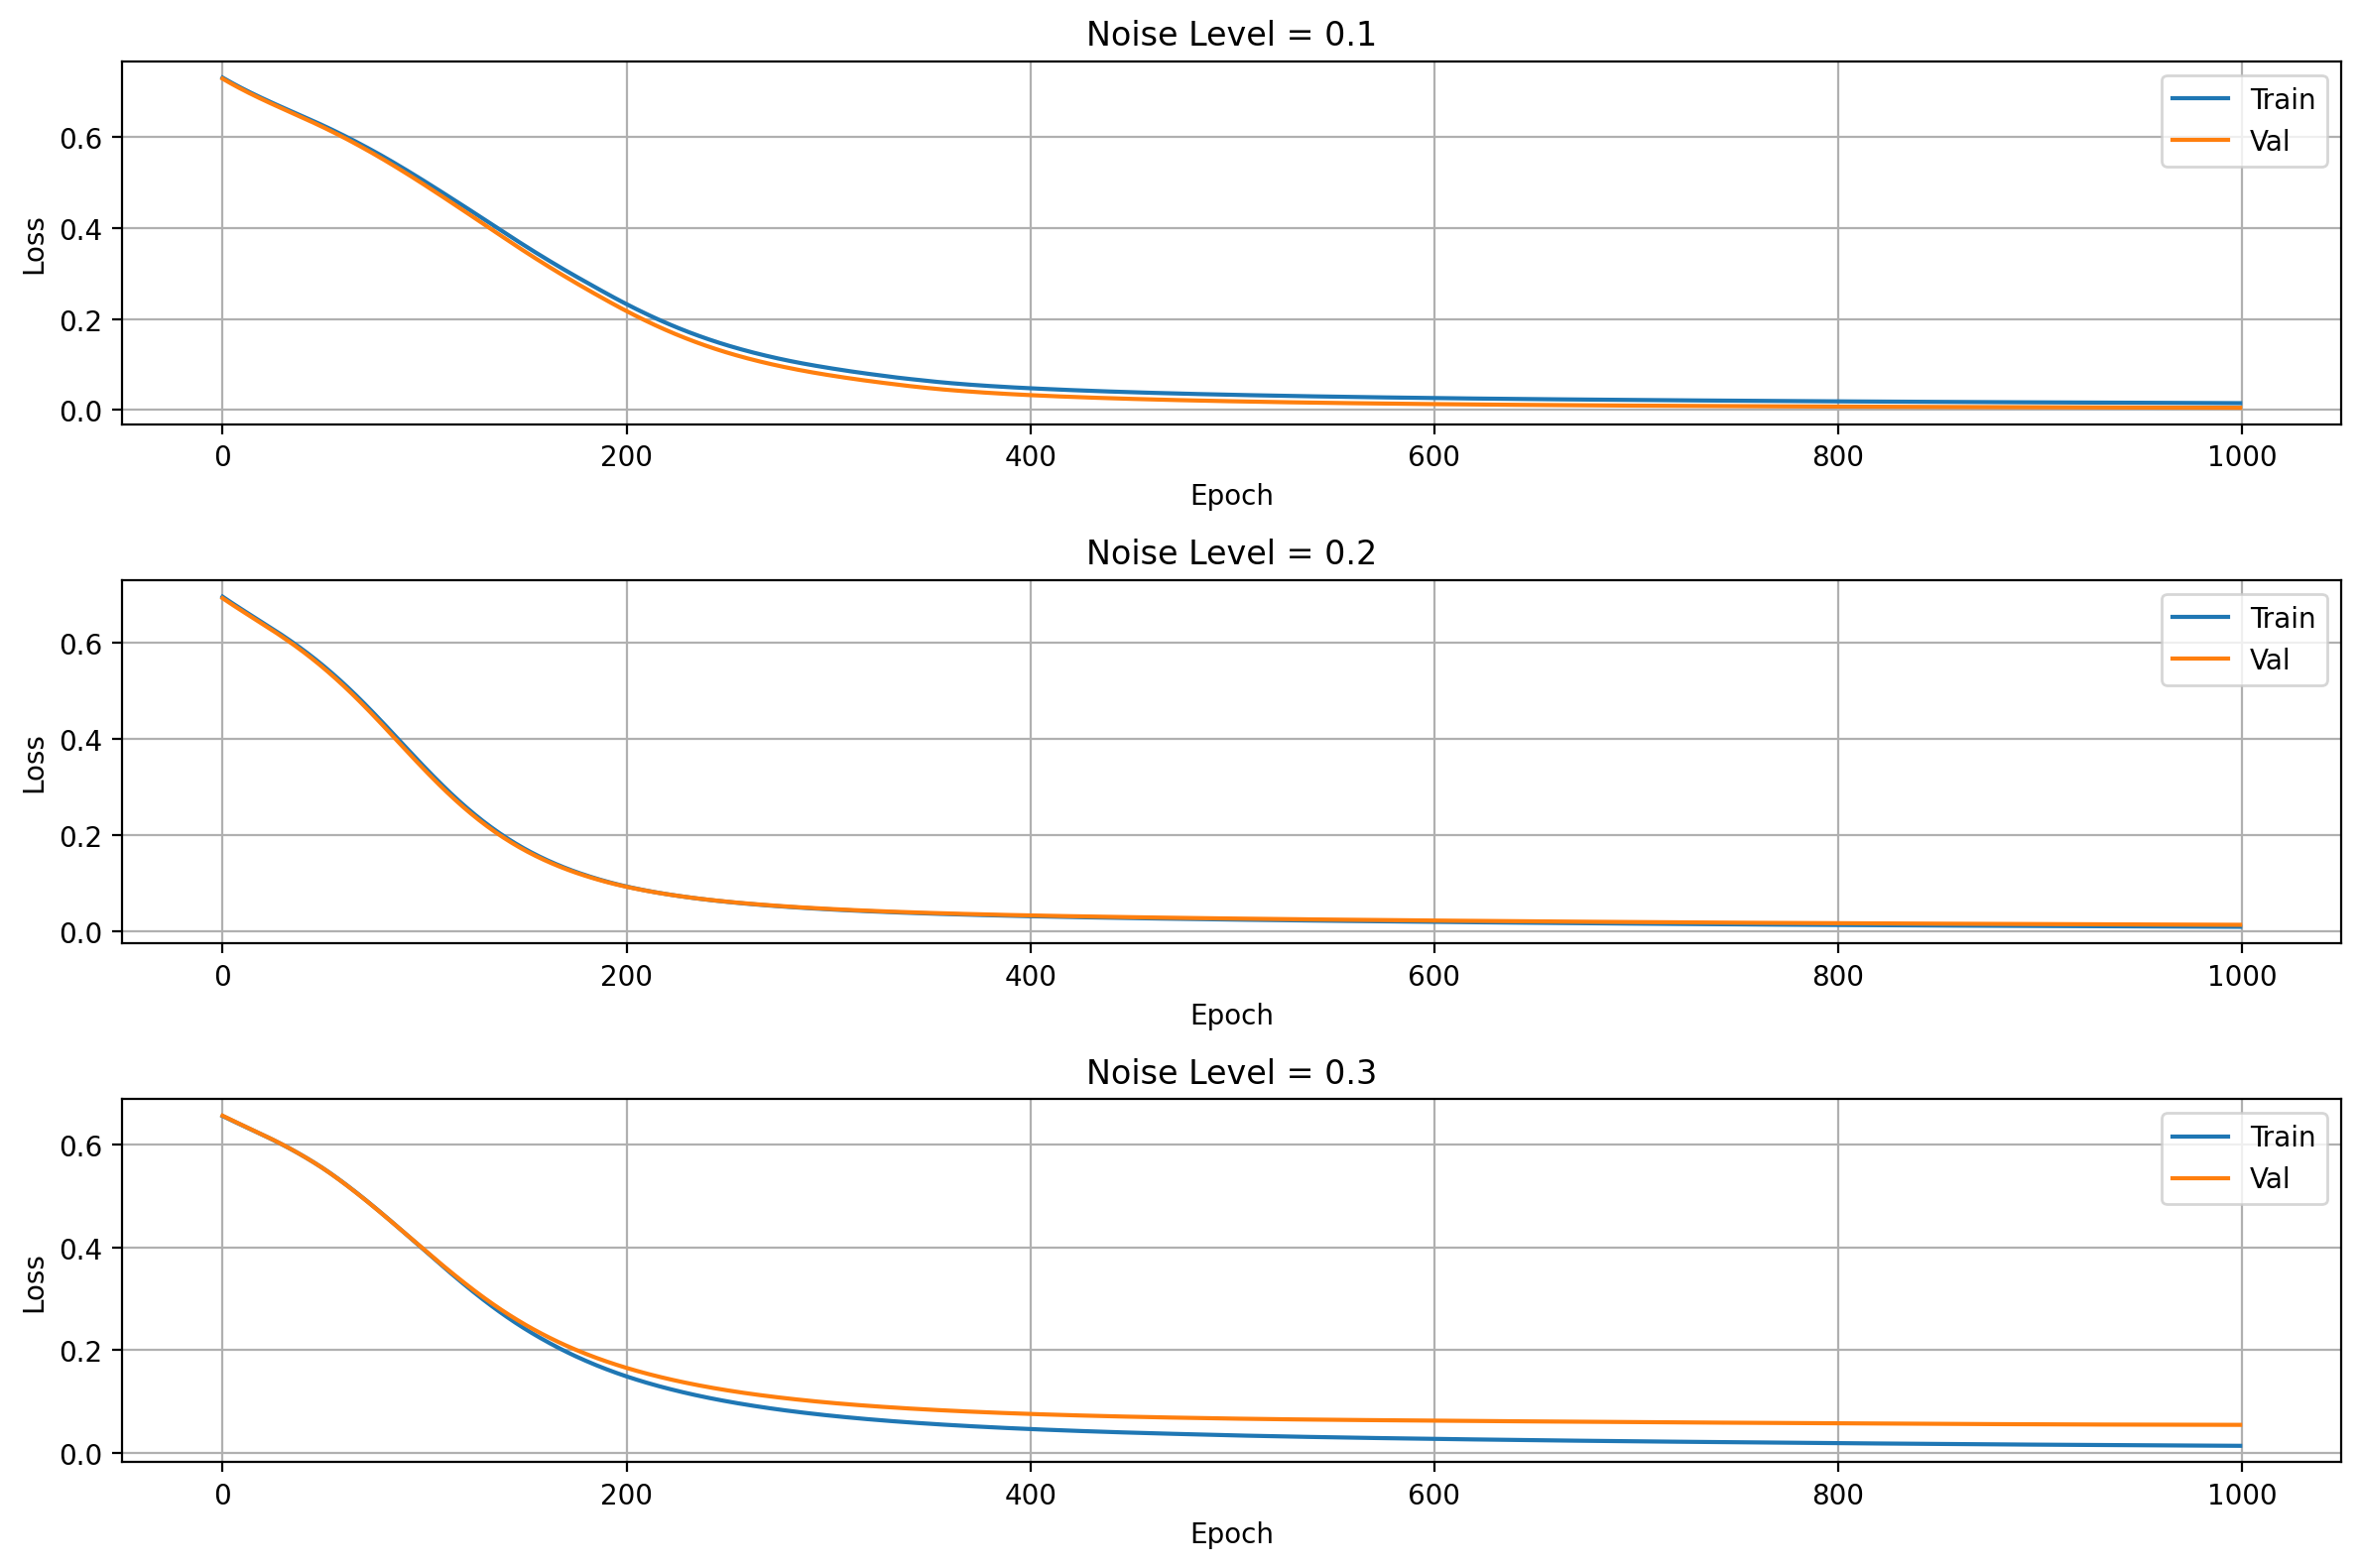

In [100]:
noise_levels = ['0.1', '0.2', '0.3']
train_losses = [train_loss_01, train_loss_02, train_loss_03]
val_losses = [val_loss_01, val_loss_02, val_loss_03]

plt.figure(figsize=(12, 8))
for i, (tr, va, n) in enumerate(zip(train_losses, val_losses, noise_levels)):
    plt.subplot(3, 1, i+1)
    plt.plot(tr, label='Train')
    plt.plot(va, label='Val')
    plt.title(f"Noise Level = {n}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()


## MLP with L1 regularization

In [51]:
def MLP__L1_regularization(model, device, X_train, y_train, X_val, y_val, 
                           lr=1e-3, epochs=1000, patience=50, l1_lambda=1e-5):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)

    best_val_loss = float('inf')
    best_val_acc = 0.0               # 🔹 track best accuracy
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs+1):
        # ===== Training =====
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        ce_loss = loss_fn(logits, y_train)

        l1_loss = torch.tensor(0.0, device=device)
        for param in model.parameters():
            l1_loss += torch.sum(torch.abs(param))

        loss = ce_loss + l1_lambda * l1_loss
        loss.backward()
        optimizer.step()

        # ===== Validation =====
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            val_loss = loss_fn(val_logits, y_val)

            val_preds = torch.argmax(val_logits, dim=1)
            val_acc = (val_preds == y_val).float().mean().item()   # 🔹 validation accuracy

        # ===== Track best model =====
        if val_loss < best_val_loss - 1e-5:  # small threshold
            best_val_loss = val_loss
            best_val_acc = val_acc                     # 🔹 update best accuracy
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        # ===== Early stopping =====
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}, best val loss = {best_val_loss:.4f}, best val acc = {best_val_acc:.4f}")
            break

        # ===== Print every 100 epochs =====
        if epoch % 100 == 0:
            print('---------')
            print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | Val Acc: {val_acc:.4f}")
            print(f"Epoch {epoch} | CE: {ce_loss.item():.4f} | L1: {l1_loss.item():.4f} | Total: {loss.item():.4f}")
            print('---------\n')

    # Load best model
    model.load_state_dict(best_model_state)
    print(f"Training complete. Best Val Accuracy: {best_val_acc:.4f}")
    
    return model, best_val_acc


In [52]:
# Note that L1 penalty is only added in the trainign model and not in the validation madel because l1 is the constraint added only during the trainign and there is no req. for l1 in validation as during trtaining we are learning the model and to control the models complexity and punish for more complex models we add the L1 reg in ti in the validation we are only using that model to predict and validate we are not further improving that model.

def MLP__L1_regularization_run(model, device, X_train, y_train, X_val, y_val, lr=1e-3, epochs=1000, patience=50, l1_lambda=1e-5):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs+1):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train)
        ce_loss = loss_fn(logits, y_train)

        l1_loss = torch.tensor(0.0, device=device)
        for param in model.parameters():
            l1_loss += torch.sum(torch.abs(param))
            
        
        loss = ce_loss + l1_lambda * l1_loss

        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_logits = model(X_val)
            val_loss = loss_fn(val_logits, y_val)

        if val_loss < best_val_loss - 1e-5:  # small threshold for improvement
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            # print(f"Early stopping at epoch {epoch}, best val loss = {best_val_loss:.4f}")
            break
        
        # if epoch % 50 == 0:
        #     print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # if epoch % 50 == 0:
        #     print(f"Epoch {epoch} | CE: {ce_loss.item():.4f} | L1: {l1_loss.item():.4f} | Total: {loss.item():.4f}")


    # Load best model
    model.load_state_dict(best_model_state)
    return model

In [53]:
model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
trained_MLP_L1, best_val_acc = MLP__L1_regularization(model, device, X_train, y_train, X_val, y_val, lr=1e-3, epochs=100, patience=50)
print("Best Validation Accuracy:", best_val_acc)

---------
Epoch 0 | Train Loss: 0.6824 | Val Loss: 0.6811 | Val Acc: 0.5100
Epoch 0 | CE: 0.6821 | L1: 31.7522 | Total: 0.6824
---------

---------
Epoch 100 | Train Loss: 0.4220 | Val Loss: 0.4121 | Val Acc: 0.8700
Epoch 100 | CE: 0.4217 | L1: 31.6843 | Total: 0.4220
---------

Training complete. Best Val Accuracy: 0.8700
Best Validation Accuracy: 0.8700000047683716


In [55]:
lambda_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-1]
results_val = []

for l1_lambda in lambda_grid:
    print(f"\nTraining with L1 λ = {l1_lambda:.0e}")
    model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim).to(device)

    # Train model with L1 regularization
    trained_model = MLP__L1_regularization_run(
        model, device, X_train, y_train, X_val, y_val,
        lr=1e-3, epochs=100, patience=50, l1_lambda=l1_lambda
    )

    trained_model.eval()
    with torch.no_grad():
        val_logits = trained_model(torch.tensor(X_val, dtype=torch.float32).to(device))
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
        auc = roc_auc_score(y_val, val_probs)

    # Compute layerwise sparsity (fraction of weights == 0)
    layer_sparsity = {}
    print("--------")
    for name, param in trained_model.named_parameters():
        if "weight" in name:
            total = param.numel()
            zeros = torch.sum(param == 0).item()
            sparsity = zeros / total
            layer_sparsity[name] = sparsity
            print(f"λ={l1_lambda:.0e} | {name} sparsity: {sparsity:.4f}")

    results_val.append({
        "lambda": l1_lambda,
        "val_auc": auc,
        "layer_sparsity": layer_sparsity
    })



Training with L1 λ = 1e-06
--------
λ=1e-06 | fc1.weight sparsity: 0.0000
λ=1e-06 | fc2.weight sparsity: 0.0000
λ=1e-06 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-06
--------
λ=3e-06 | fc1.weight sparsity: 0.0000
λ=3e-06 | fc2.weight sparsity: 0.0000
λ=3e-06 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-05
--------
λ=1e-05 | fc1.weight sparsity: 0.0000
λ=1e-05 | fc2.weight sparsity: 0.0000
λ=1e-05 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-05
--------
λ=3e-05 | fc1.weight sparsity: 0.0000
λ=3e-05 | fc2.weight sparsity: 0.0000
λ=3e-05 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-04
--------
λ=1e-04 | fc1.weight sparsity: 0.0000
λ=1e-04 | fc2.weight sparsity: 0.0000
λ=1e-04 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-04
--------
λ=3e-04 | fc1.weight sparsity: 0.0000
λ=3e-04 | fc2.weight sparsity: 0.0000
λ=3e-04 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-01
--------
λ=1e-01 | fc1.weight sparsity: 0.0000
λ=1e-01 | fc2.weigh


===== Summary =====
λ=1e-06 | AUROC=0.9376 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-06 | AUROC=0.9996 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-05 | AUROC=0.9852 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-05 | AUROC=0.9948 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-04 | AUROC=0.9988 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-04 | AUROC=0.9896 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-01 | AUROC=0.4704 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000


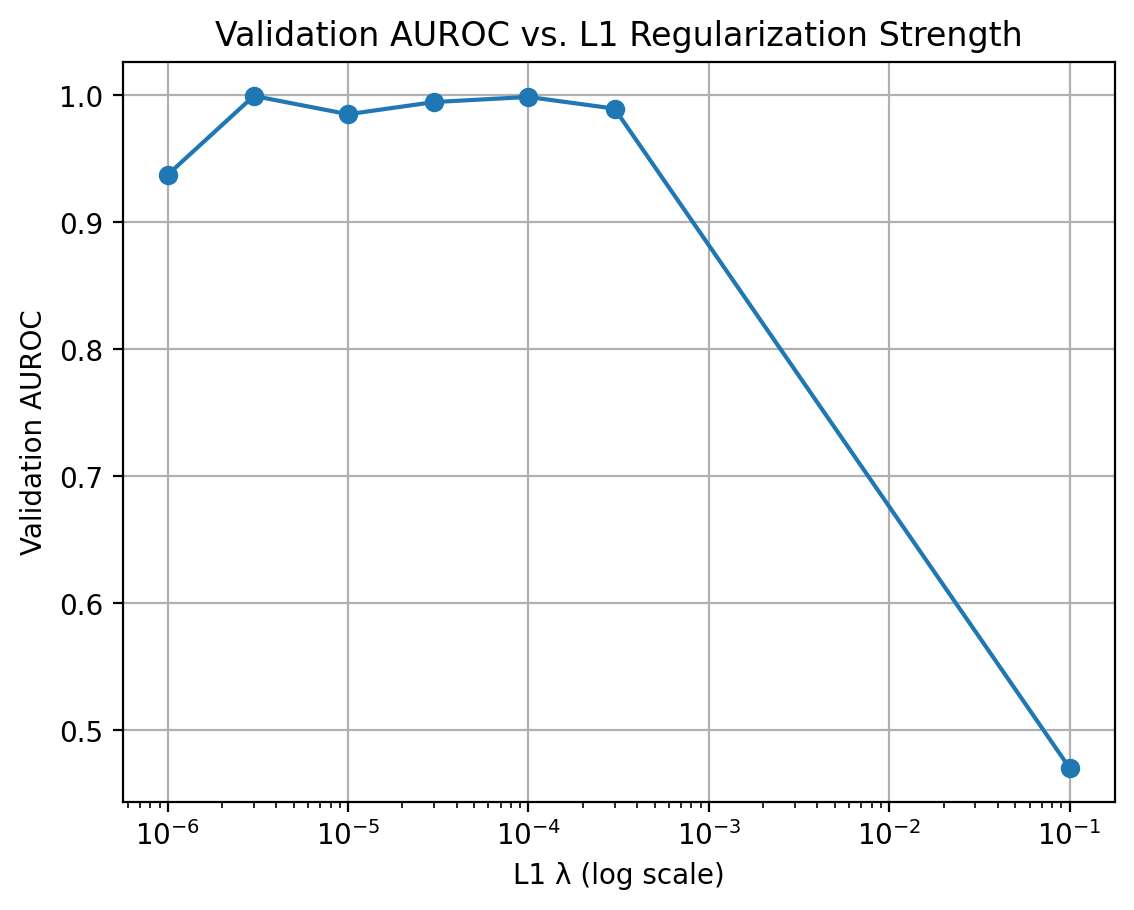

In [56]:
print("\n===== Summary =====")
for res in results_val:
    print(f"λ={res['lambda']:.0e} | AUROC={res['val_auc']:.4f} | "
          f"fc1: {res['layer_sparsity'].get('fc1.weight', 0):.4f}, "
          f"fc2: {res['layer_sparsity'].get('fc2.weight', 0):.4f}, "
          f"fc3: {res['layer_sparsity'].get('fc3.weight', 0):.4f}"
          )
    


plt.figure()
plt.plot([r['lambda'] for r in results_val],
         [r['val_auc'] for r in results_val],
         marker='o')
plt.xscale('log')
plt.xlabel('L1 λ (log scale)')
plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs. L1 Regularization Strength')
plt.grid(True)
plt.show()

In [57]:
model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
trained_MLP_L1 = MLP__L1_regularization(model, device, X_train, y_train, X_test_01, y_test_01, lr=1e-3, epochs=100, patience=50)

---------
Epoch 0 | Train Loss: 0.6751 | Val Loss: 0.6718 | Val Acc: 0.6600
Epoch 0 | CE: 0.6747 | L1: 32.8121 | Total: 0.6751
---------

---------
Epoch 100 | Train Loss: 0.3638 | Val Loss: 0.3519 | Val Acc: 0.9960
Epoch 100 | CE: 0.3635 | L1: 33.8293 | Total: 0.3638
---------

Training complete. Best Val Accuracy: 0.9960


In [ ]:
lambda_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-1]
results_01 = []

for l1_lambda in lambda_grid:
    print(f"\nTraining with L1 λ = {l1_lambda:.0e}")
    model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim).to(device)

    # Train model with L1 regularization
    trained_model = MLP__L1_regularization_run(
        model, device, X_train, y_train, X_test_01, y_test_01,
        lr=1e-3, epochs=100, patience=50, l1_lambda=l1_lambda
    )

    trained_model.eval()
    with torch.no_grad():
        val_logits = trained_model(torch.tensor(X_test_01, dtype=torch.float32).to(device))
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
        auc = roc_auc_score(y_test_01, val_probs)

    # Compute layerwise sparsity (fraction of weights == 0)
    layer_sparsity = {}
    print("--------")
    for name, param in trained_model.named_parameters():
        if "weight" in name:
            total = param.numel()
            zeros = torch.sum(param == 0).item()
            sparsity = zeros / total
            layer_sparsity[name] = sparsity
            print(f"λ={l1_lambda:.0e} | {name} sparsity: {sparsity:.4f}")

    results_01.append({
        "lambda": l1_lambda,
        "val_auc": auc,
        "layer_sparsity": layer_sparsity
    })



Training with L1 λ = 1e-06
--------
λ=1e-06 | fc1.weight sparsity: 0.0000
λ=1e-06 | fc2.weight sparsity: 0.0000
λ=1e-06 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-06
--------
λ=3e-06 | fc1.weight sparsity: 0.0000
λ=3e-06 | fc2.weight sparsity: 0.0000
λ=3e-06 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-05
--------
λ=1e-05 | fc1.weight sparsity: 0.0000
λ=1e-05 | fc2.weight sparsity: 0.0000
λ=1e-05 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-05
--------
λ=3e-05 | fc1.weight sparsity: 0.0000
λ=3e-05 | fc2.weight sparsity: 0.0000
λ=3e-05 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-04
--------
λ=1e-04 | fc1.weight sparsity: 0.0000
λ=1e-04 | fc2.weight sparsity: 0.0000
λ=1e-04 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-04
--------
λ=3e-04 | fc1.weight sparsity: 0.0000
λ=3e-04 | fc2.weight sparsity: 0.0000
λ=3e-04 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-01
--------
λ=1e-01 | fc1.weight sparsity: 0.0000
λ=1e-01 | fc2.weigh


===== Summary =====
λ=1e-06 | AUROC=0.9606 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-06 | AUROC=0.9991 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-05 | AUROC=1.0000 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-05 | AUROC=0.9937 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-04 | AUROC=1.0000 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-04 | AUROC=0.9851 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-01 | AUROC=0.0564 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000


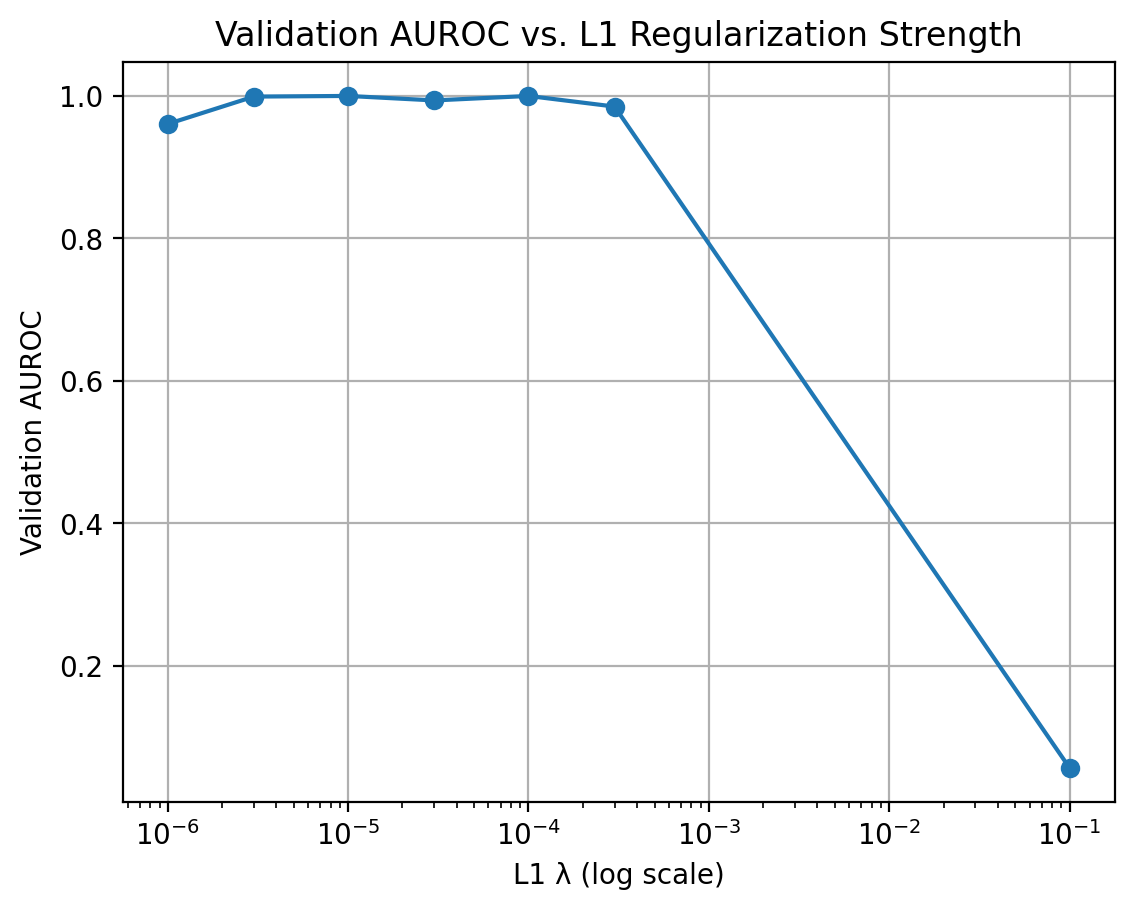

In [59]:
print("\n===== Summary =====")
for res in results_01:
    print(f"λ={res['lambda']:.0e} | AUROC={res['val_auc']:.4f} | "
          f"fc1: {res['layer_sparsity'].get('fc1.weight', 0):.4f}, "
          f"fc2: {res['layer_sparsity'].get('fc2.weight', 0):.4f}, "
          f"fc3: {res['layer_sparsity'].get('fc3.weight', 0):.4f}"
          )
    


plt.figure()
plt.plot([r['lambda'] for r in results_01],
         [r['val_auc'] for r in results_01],
         marker='o')
plt.xscale('log')
plt.xlabel('L1 λ (log scale)')
plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs. L1 Regularization Strength')
plt.grid(True)
plt.show()

In [82]:
model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
trained_MLP_02 = MLP__L1_regularization(model, device, X_train, y_train, X_test_02, y_test_02, lr=1e-3, epochs=100, patience=50)

---------
Epoch 0 | Train Loss: 0.6919 | Val Loss: 0.6895 | Val Acc: 0.5000
Epoch 0 | CE: 0.6916 | L1: 30.0359 | Total: 0.6919
---------

---------
Epoch 100 | Train Loss: 0.4208 | Val Loss: 0.4151 | Val Acc: 0.9360
Epoch 100 | CE: 0.4205 | L1: 29.8667 | Total: 0.4208
---------

Training complete. Best Val Accuracy: 0.9360


In [83]:
lambda_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-1]
results_02 = []

for l1_lambda in lambda_grid:
    print(f"\nTraining with L1 λ = {l1_lambda:.0e}")
    model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim).to(device)

    # Train model with L1 regularization
    trained_model = MLP__L1_regularization_run(
        model, device, X_train, y_train, X_test_02, y_test_02,
        lr=1e-3, epochs=100, patience=50, l1_lambda=l1_lambda
    )

    trained_model.eval()
    with torch.no_grad():
        val_logits = trained_model(torch.tensor(X_test_02, dtype=torch.float32).to(device))
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
        auc = roc_auc_score(y_test_02, val_probs)

    # Compute layerwise sparsity (fraction of weights == 0)
    layer_sparsity = {}
    print("--------")
    for name, param in trained_model.named_parameters():
        if "weight" in name:
            total = param.numel()
            zeros = torch.sum(param == 0).item()
            sparsity = zeros / total
            layer_sparsity[name] = sparsity
            print(f"λ={l1_lambda:.0e} | {name} sparsity: {sparsity:.4f}")

    results_02.append({
        "lambda": l1_lambda,
        "val_auc": auc,
        "layer_sparsity": layer_sparsity,
        "model": trained_model        # ✅ SAVE MODEL
    })



best_l1_noise02 = max(results_02, key=lambda x: x["val_auc"])
best_l1_model_noise02 = best_l1_noise02["model"]
best_l1_lambda_noise02 = best_l1_noise02["lambda"]

print("\n===== BEST L1 MODEL (Noise 0.2) =====")
print(f"Best λ = {best_l1_lambda_noise02}, AUROC = {best_l1_noise02['val_auc']:.4f}")



Training with L1 λ = 1e-06
--------
λ=1e-06 | fc1.weight sparsity: 0.0000
λ=1e-06 | fc2.weight sparsity: 0.0000
λ=1e-06 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-06
--------
λ=3e-06 | fc1.weight sparsity: 0.0000
λ=3e-06 | fc2.weight sparsity: 0.0000
λ=3e-06 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-05
--------
λ=1e-05 | fc1.weight sparsity: 0.0000
λ=1e-05 | fc2.weight sparsity: 0.0000
λ=1e-05 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-05
--------
λ=3e-05 | fc1.weight sparsity: 0.0000
λ=3e-05 | fc2.weight sparsity: 0.0000
λ=3e-05 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-04
--------
λ=1e-04 | fc1.weight sparsity: 0.0000
λ=1e-04 | fc2.weight sparsity: 0.0000
λ=1e-04 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-04
--------
λ=3e-04 | fc1.weight sparsity: 0.0000
λ=3e-04 | fc2.weight sparsity: 0.0000
λ=3e-04 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-01
--------
λ=1e-01 | fc1.weight sparsity: 0.0000
λ=1e-01 | fc2.weigh


===== Summary =====
λ=1e-06 | AUROC=0.9980 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-06 | AUROC=0.9885 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-05 | AUROC=0.9976 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-05 | AUROC=0.9968 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-04 | AUROC=0.9930 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-04 | AUROC=0.9955 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-01 | AUROC=0.0602 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000


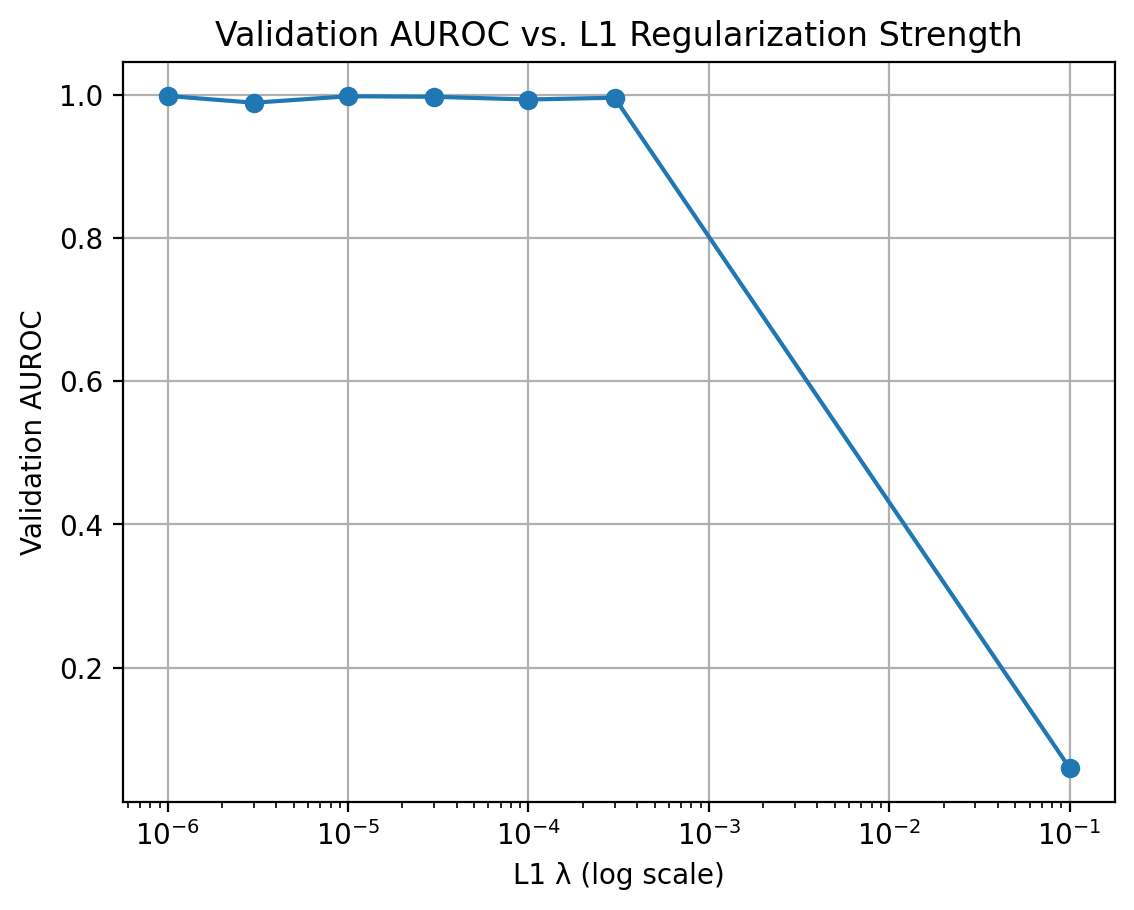

In [84]:
print("\n===== Summary =====")
for res in results_02:
    print(f"λ={res['lambda']:.0e} | AUROC={res['val_auc']:.4f} | "
          f"fc1: {res['layer_sparsity'].get('fc1.weight', 0):.4f}, "
          f"fc2: {res['layer_sparsity'].get('fc2.weight', 0):.4f}, "
          f"fc3: {res['layer_sparsity'].get('fc3.weight', 0):.4f}"
          )
    


plt.figure()
plt.plot([r['lambda'] for r in results_02],
         [r['val_auc'] for r in results_02],
         marker='o')
plt.xscale('log')
plt.xlabel('L1 λ (log scale)')
plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs. L1 Regularization Strength')
plt.grid(True)
plt.show()

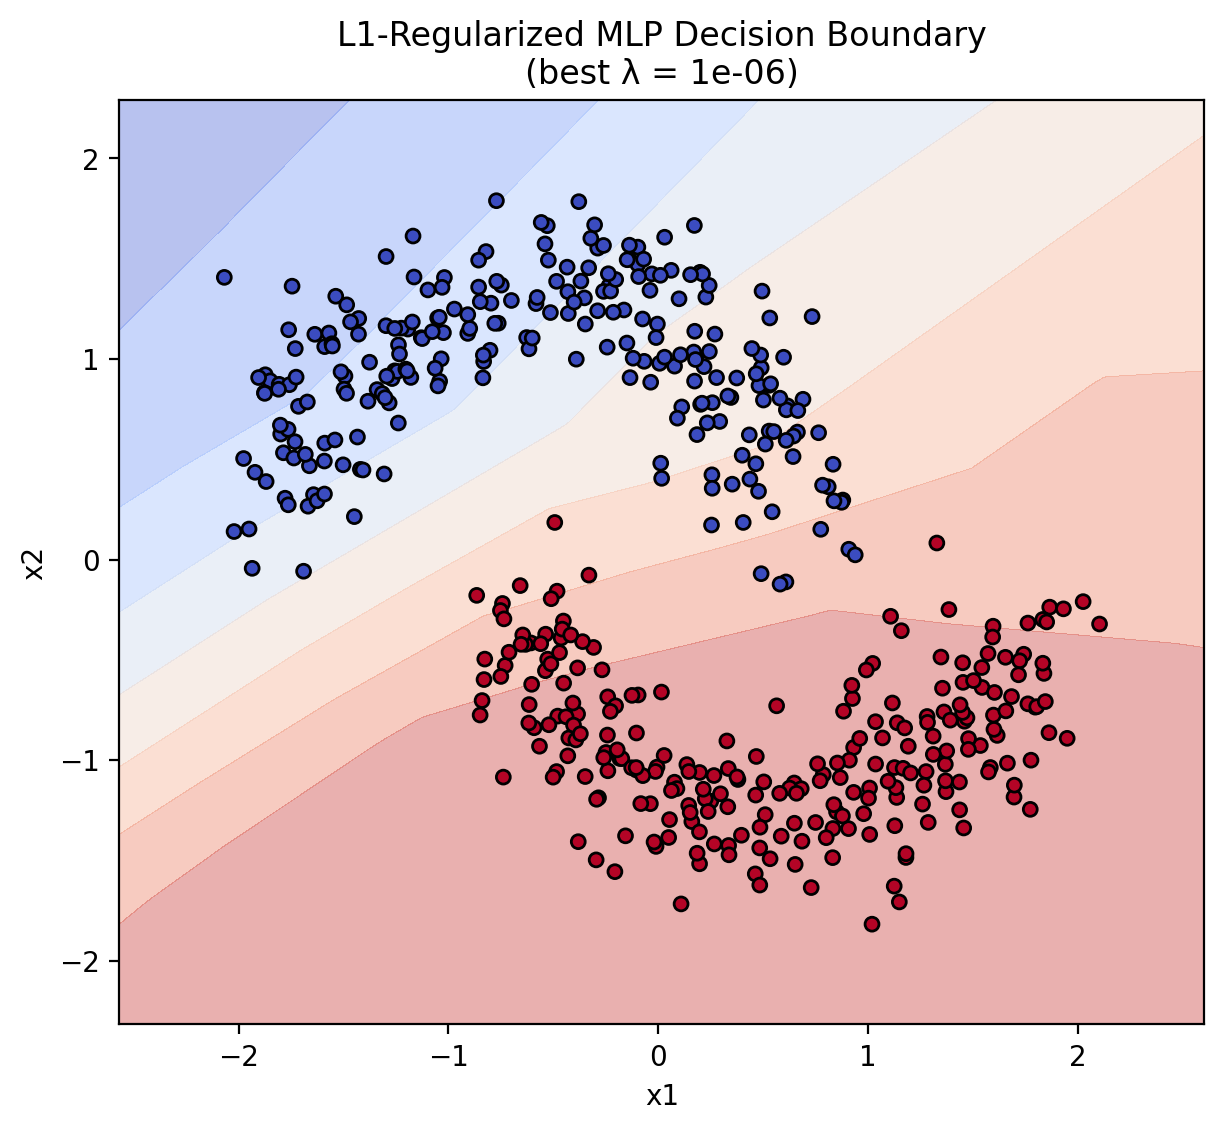

In [85]:
def plot_decision_boundary_torch(model, X, y, title):
    import numpy as np
    import matplotlib.pyplot as plt
    import torch

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]

    model.eval()
    with torch.no_grad():
        grid_t = torch.tensor(grid, dtype=torch.float32).to(next(model.parameters()).device)
        logits = model(grid_t)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

    Z = probs.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', s=25)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")


plt.figure(figsize=(7, 6))
plot_decision_boundary_torch(
    best_l1_model_noise02,
    X_test_02,
    y_test_02,
    title=f"L1-Regularized MLP Decision Boundary\n(best λ = {best_l1_lambda_noise02})"
)
plt.show()


In [103]:
def make_imbalanced_safe(X, y, majority_class=0, ratio_majority=0.7):
    import numpy as np
    
    # Indices of classes
    idx_major = np.where(y == majority_class)[0]
    idx_minor = np.where(y != majority_class)[0]
    
    # Available counts
    n_major_available = len(idx_major)
    n_minor_available = len(idx_minor)
    
    # Desired counts based on ratio
    total = len(y)
    desired_major = int(total * ratio_majority)
    desired_minor = total - desired_major
    
    # Clip to available samples
    desired_major = min(desired_major, n_major_available)
    desired_minor = min(desired_minor, n_minor_available)
    
    # Sample without replacement
    selected_major = np.random.choice(idx_major, desired_major, replace=False)
    selected_minor = np.random.choice(idx_minor, desired_minor, replace=False)
    
    selected = np.concatenate([selected_major, selected_minor])
    np.random.shuffle(selected)
    
    return X[selected], y[selected]


In [104]:
X_train_imb, y_train_imb = make_imbalanced_safe(
    X_train, y_train, majority_class=0, ratio_majority=0.7
)

print("Class 0 % =", np.mean(y_train_imb == 0))
print("Class 1 % =", np.mean(y_train_imb == 1))


Class 0 % = 0.625
Class 1 % = 0.375


In [106]:
model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
trained_MLP_02 = MLP__L1_regularization(model, device, X_train, y_train, X_train_imb, y_train_imb, lr=1e-3, epochs=100, patience=50)

---------
Epoch 0 | Train Loss: 0.7024 | Val Loss: 0.6779 | Val Acc: 0.6250
Epoch 0 | CE: 0.7021 | L1: 31.1128 | Total: 0.7024
---------

---------
Epoch 100 | Train Loss: 0.4319 | Val Loss: 0.4364 | Val Acc: 0.9313
Epoch 100 | CE: 0.4315 | L1: 31.9334 | Total: 0.4319
---------

Training complete. Best Val Accuracy: 0.9313


In [107]:
model.eval()
with torch.no_grad():
    logits = model(torch.tensor(X_test_02, dtype=torch.float32).to(device))
    probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

from sklearn.metrics import accuracy_score, roc_auc_score

y_pred = (probs >= 0.5).astype(int)

acc = accuracy_score(y_test_02, y_pred)
auc = roc_auc_score(y_test_02, probs)

print("Accuracy:", acc)
print("AUROC:", auc)


Accuracy: 0.934
AUROC: 0.9916


In [86]:
model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
trained_MLP_L1 = MLP__L1_regularization(model, device, X_train, y_train, X_test_03, y_test_03, lr=1e-3, epochs=100, patience=50)

---------
Epoch 0 | Train Loss: 0.7159 | Val Loss: 0.7116 | Val Acc: 0.2620
Epoch 0 | CE: 0.7156 | L1: 28.8153 | Total: 0.7159
---------

---------
Epoch 100 | Train Loss: 0.4243 | Val Loss: 0.4242 | Val Acc: 0.9280
Epoch 100 | CE: 0.4239 | L1: 31.6017 | Total: 0.4243
---------

Training complete. Best Val Accuracy: 0.9280


In [64]:
lambda_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-1]
results_03 = []

for l1_lambda in lambda_grid:
    print(f"\nTraining with L1 λ = {l1_lambda:.0e}")
    model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim).to(device)

    # Train model with L1 regularization
    trained_model = MLP__L1_regularization_run(
        model, device, X_train, y_train, X_test_03, y_test_03,
        lr=1e-3, epochs=100, patience=50, l1_lambda=l1_lambda
    )

    trained_model.eval()
    with torch.no_grad():
        val_logits = trained_model(torch.tensor(X_test_03, dtype=torch.float32).to(device))
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
        auc = roc_auc_score(y_test_03, val_probs)

    # Compute layerwise sparsity (fraction of weights == 0)
    layer_sparsity = {}
    print("--------")
    for name, param in trained_model.named_parameters():
        if "weight" in name:
            total = param.numel()
            zeros = torch.sum(param == 0).item()
            sparsity = zeros / total
            layer_sparsity[name] = sparsity
            print(f"λ={l1_lambda:.0e} | {name} sparsity: {sparsity:.4f}")

    results_03.append({
        "lambda": l1_lambda,
        "val_auc": auc,
        "layer_sparsity": layer_sparsity
    })



Training with L1 λ = 1e-06
--------
λ=1e-06 | fc1.weight sparsity: 0.0000
λ=1e-06 | fc2.weight sparsity: 0.0000
λ=1e-06 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-06
--------
λ=3e-06 | fc1.weight sparsity: 0.0000
λ=3e-06 | fc2.weight sparsity: 0.0000
λ=3e-06 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-05
--------
λ=1e-05 | fc1.weight sparsity: 0.0000
λ=1e-05 | fc2.weight sparsity: 0.0000
λ=1e-05 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-05
--------
λ=3e-05 | fc1.weight sparsity: 0.0000
λ=3e-05 | fc2.weight sparsity: 0.0000
λ=3e-05 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-04
--------
λ=1e-04 | fc1.weight sparsity: 0.0000
λ=1e-04 | fc2.weight sparsity: 0.0000
λ=1e-04 | fc3.weight sparsity: 0.0000

Training with L1 λ = 3e-04
--------
λ=3e-04 | fc1.weight sparsity: 0.0000
λ=3e-04 | fc2.weight sparsity: 0.0000
λ=3e-04 | fc3.weight sparsity: 0.0000

Training with L1 λ = 1e-01
--------
λ=1e-01 | fc1.weight sparsity: 0.0000
λ=1e-01 | fc2.weigh


===== Summary =====
λ=1e-06 | AUROC=0.9651 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-06 | AUROC=0.9967 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-05 | AUROC=0.9889 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-05 | AUROC=0.9782 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-04 | AUROC=0.9911 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=3e-04 | AUROC=0.9772 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000
λ=1e-01 | AUROC=0.0079 | fc1: 0.0000, fc2: 0.0000, fc3: 0.0000


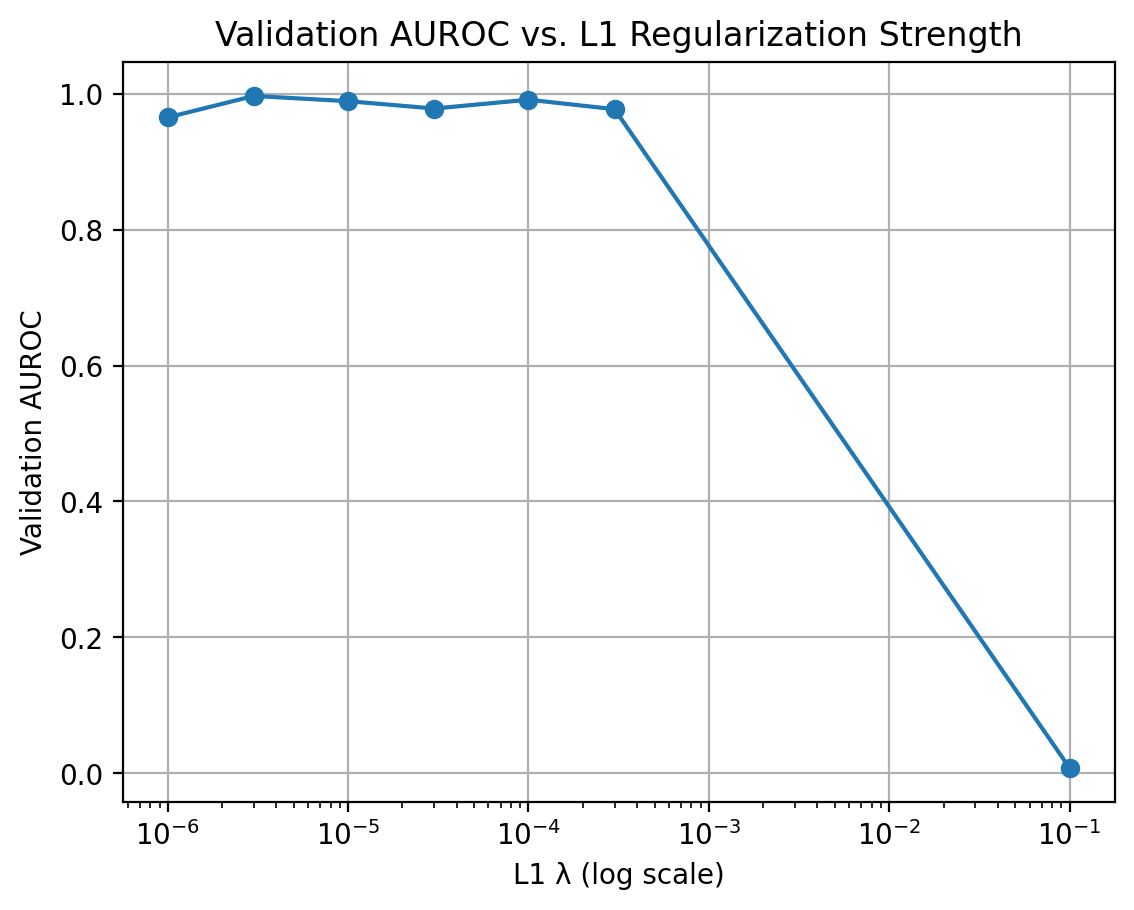

In [65]:
print("\n===== Summary =====")
for res in results_03:
    print(f"λ={res['lambda']:.0e} | AUROC={res['val_auc']:.4f} | "
          f"fc1: {res['layer_sparsity'].get('fc1.weight', 0):.4f}, "
          f"fc2: {res['layer_sparsity'].get('fc2.weight', 0):.4f}, "
          f"fc3: {res['layer_sparsity'].get('fc3.weight', 0):.4f}"
          )
    


plt.figure()
plt.plot([r['lambda'] for r in results_03],
         [r['val_auc'] for r in results_03],
         marker='o')
plt.xscale('log')
plt.xlabel('L1 λ (log scale)')
plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs. L1 Regularization Strength')
plt.grid(True)
plt.show()

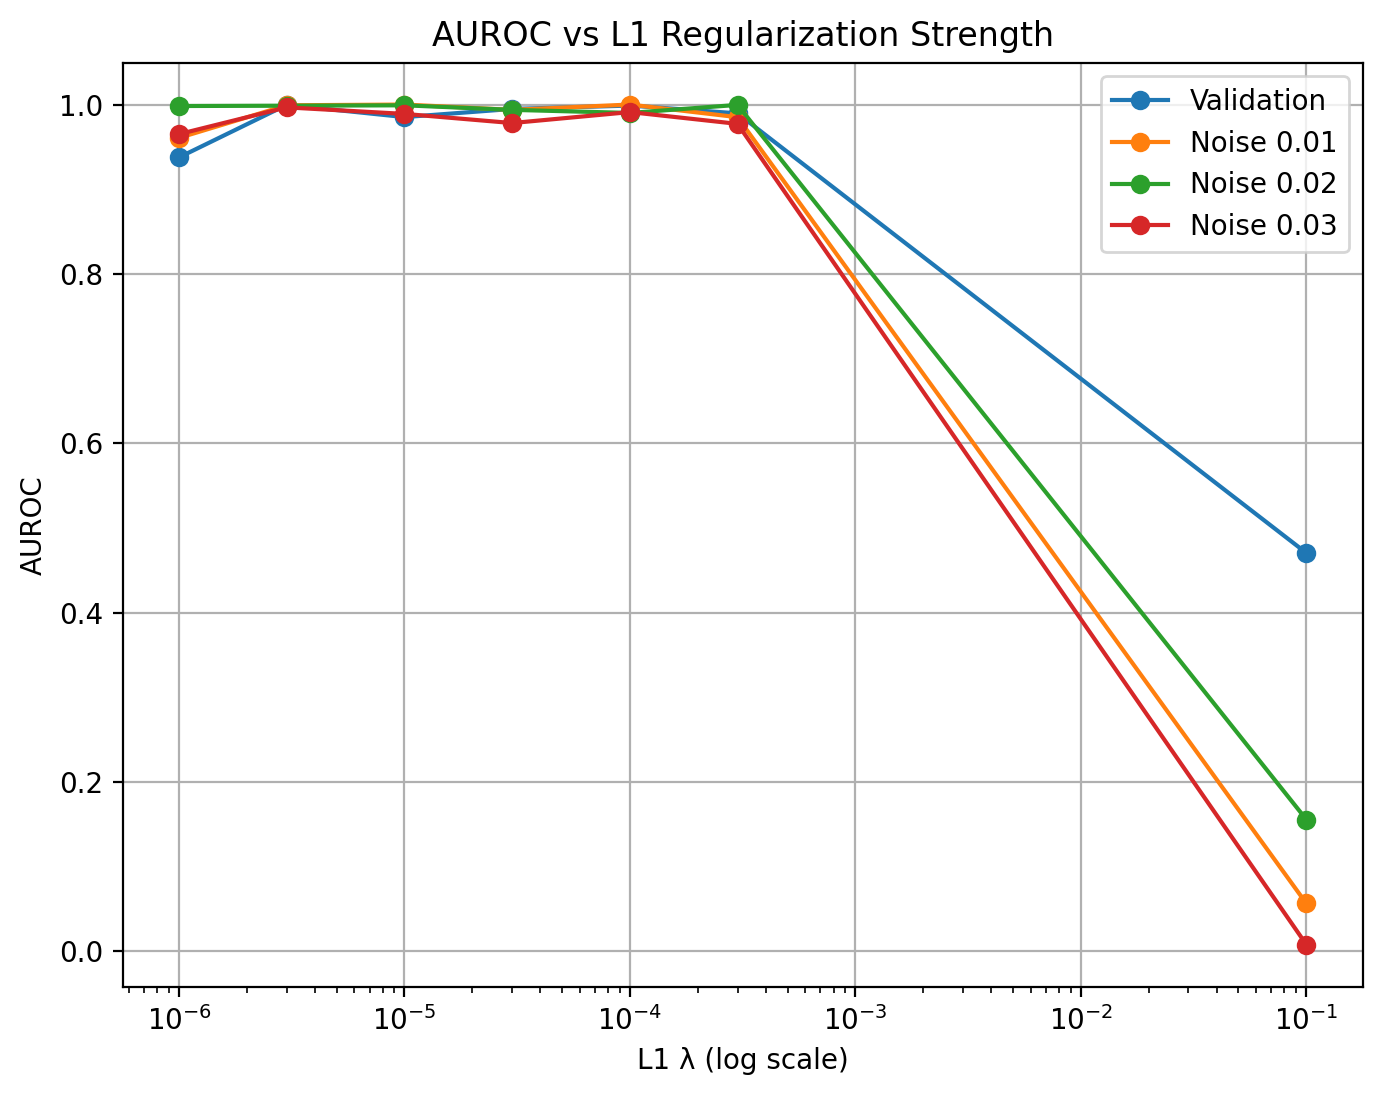

In [67]:
# ===== Combined AUROC Plot =====

lambda_grid = [r['lambda'] for r in results_val]

auroc_val = [r['val_auc'] for r in results_val]
auroc_01  = [r['val_auc'] for r in results_01]
auroc_02  = [r['val_auc'] for r in results_02]
auroc_03  = [r['val_auc'] for r in results_03]

plt.figure(figsize=(8,6))
plt.plot(lambda_grid, auroc_val, marker='o', label='Validation')
plt.plot(lambda_grid, auroc_01, marker='o', label='Noise 0.01')
plt.plot(lambda_grid, auroc_02, marker='o', label='Noise 0.02')
plt.plot(lambda_grid, auroc_03, marker='o', label='Noise 0.03')

plt.xscale('log')
plt.xlabel('L1 λ (log scale)')
plt.ylabel('AUROC')
plt.title('AUROC vs L1 Regularization Strength')
plt.grid(True)
plt.legend()
plt.show()


## MLP with L2 regulariation


Training with L2 λ = 0
L2 λ=0e+00 | Validation AUROC=0.9996

Training with L2 λ = 1e-05
L2 λ=1e-05 | Validation AUROC=0.9996

Training with L2 λ = 0.0001
L2 λ=1e-04 | Validation AUROC=0.9996

Training with L2 λ = 0.001
L2 λ=1e-03 | Validation AUROC=1.0000

Training with L2 λ = 0.003
L2 λ=3e-03 | Validation AUROC=0.9996

Training with L2 λ = 0.01
L2 λ=1e-02 | Validation AUROC=0.9996

Training with L2 λ = 0.03
L2 λ=3e-02 | Validation AUROC=0.9996

Training with L2 λ = 0.1
L2 λ=1e-01 | Validation AUROC=0.9992

Training with L2 λ = 1
L2 λ=1e+00 | Validation AUROC=0.9236

Best L2 λ = 1e-03 with AUROC = 1.0000


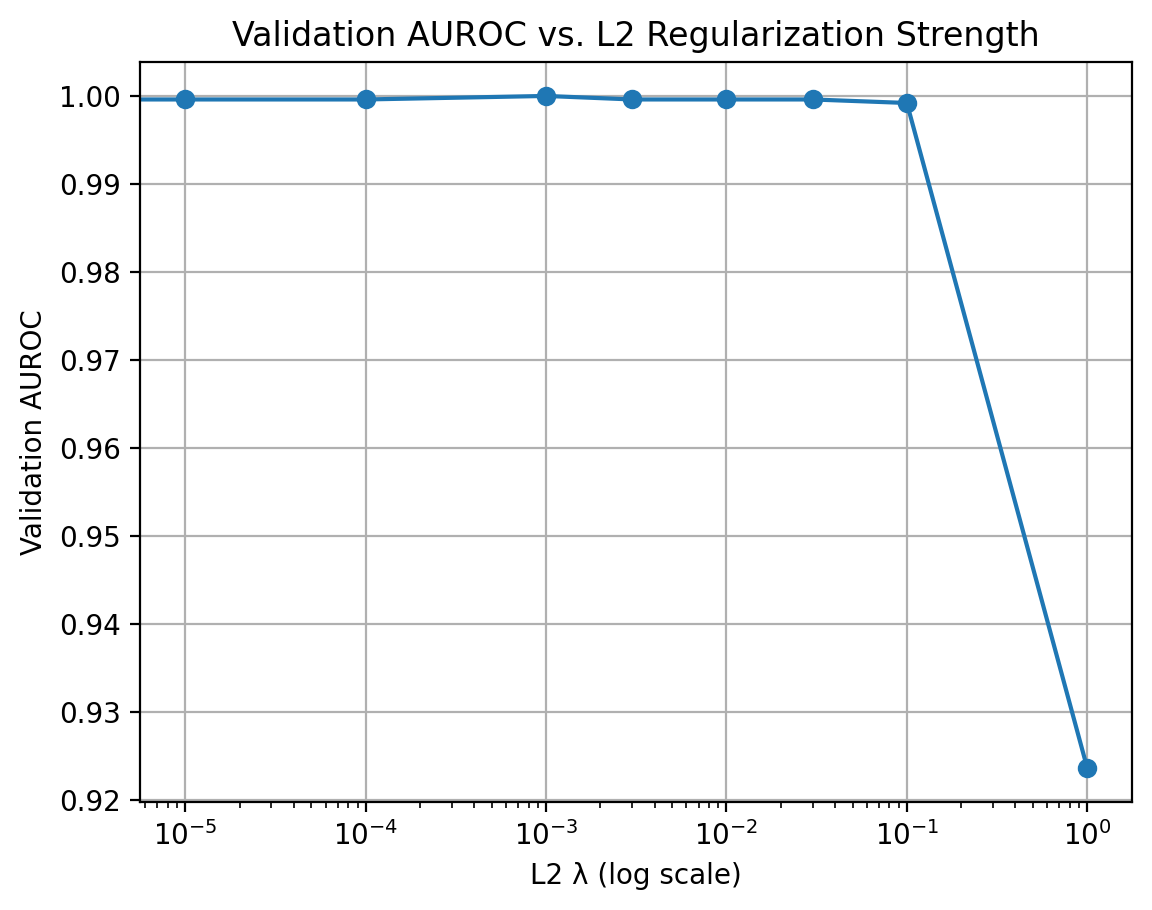

In [34]:
# Define your lambda (weight_decay) grid
l2_lambda_grid = [0, 1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 1]

results = []

for l2_lambda in l2_lambda_grid:
    print(f"\nTraining with L2 λ = {l2_lambda}")
    
    # Initialize a fresh model
    model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)
    
    # Define a modified early stopping function with current lambda
    def train_with_l2(model, device, X_train, y_train, X_val, y_val, lr=1e-3, epochs=1000, patience=50, l2_lambda=l2_lambda):
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)  # L2 penalty here
        loss_fn = nn.CrossEntropyLoss()

        X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)

        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_train_t)
            loss = loss_fn(logits, y_train_t)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_logits = model(X_val_t)
                val_loss = loss_fn(val_logits, y_val_t)

            if val_loss < best_val_loss - 1e-5:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

        model.load_state_dict(best_model_state)
        return model

    # Train model with current L2 lambda
    trained_model = train_with_l2(model, device, X_train, y_train, X_val, y_val, l2_lambda=l2_lambda)

    # Evaluate validation AUROC
    trained_model.eval()
    with torch.no_grad():
        val_logits = trained_model(torch.tensor(X_val, dtype=torch.float32).to(device))
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
        val_auc = roc_auc_score(y_val, val_probs)
    
    print(f"L2 λ={l2_lambda:.0e} | Validation AUROC={val_auc:.4f}")
    results.append({'lambda': l2_lambda, 'val_auc': val_auc})

# Find best lambda
best_result = max(results, key=lambda x: x['val_auc'])
print(f"\nBest L2 λ = {best_result['lambda']:.0e} with AUROC = {best_result['val_auc']:.4f}")

# Plot AUROC vs L2 lambda
plt.figure()
plt.plot([r['lambda'] for r in results], [r['val_auc'] for r in results], marker='o')
plt.xscale('log')
plt.xlabel('L2 λ (log scale)')
plt.ylabel('Validation AUROC')
plt.title('Validation AUROC vs. L2 Regularization Strength')
plt.grid(True)
plt.show()



Training with L2 λ = 0
λ=0e+00 | Val=1.0000 | Test01=1.0000 | Test02=0.9998 | Test03=0.9983

Training with L2 λ = 1e-05
λ=1e-05 | Val=1.0000 | Test01=1.0000 | Test02=0.9999 | Test03=0.9986

Training with L2 λ = 0.0001
λ=1e-04 | Val=1.0000 | Test01=1.0000 | Test02=1.0000 | Test03=0.9992

Training with L2 λ = 0.001
λ=1e-03 | Val=1.0000 | Test01=1.0000 | Test02=0.9998 | Test03=0.9977

Training with L2 λ = 0.003
λ=3e-03 | Val=1.0000 | Test01=1.0000 | Test02=0.9999 | Test03=0.9986

Training with L2 λ = 0.01
λ=1e-02 | Val=0.9996 | Test01=1.0000 | Test02=0.9996 | Test03=0.9971

Training with L2 λ = 0.03
λ=3e-02 | Val=0.9996 | Test01=1.0000 | Test02=0.9995 | Test03=0.9970

Training with L2 λ = 0.1
λ=1e-01 | Val=0.9992 | Test01=1.0000 | Test02=0.9991 | Test03=0.9963

Training with L2 λ = 1
λ=1e+00 | Val=0.9588 | Test01=0.9666 | Test02=0.9634 | Test03=0.9598

Best L2 λ = 0 with Val AUROC = 1.0000


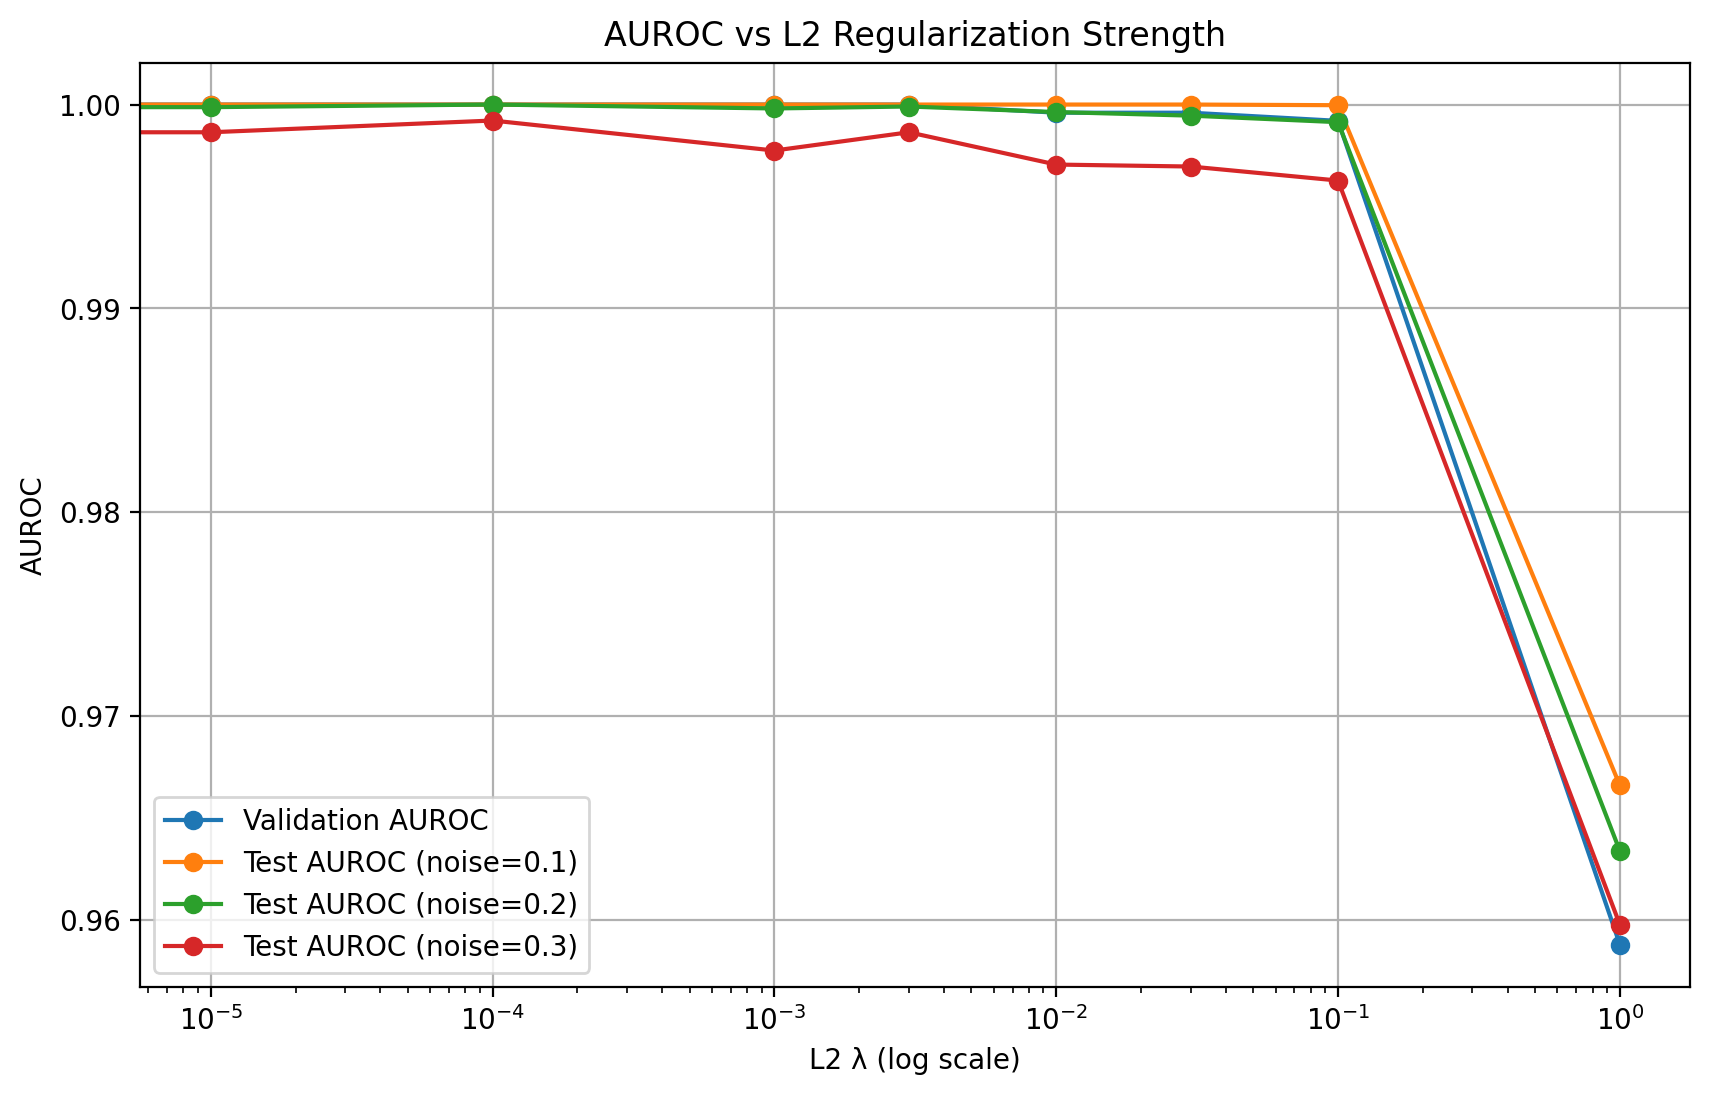

In [ ]:
# -------------------------------
# L2 Regularization Grid Search
# -------------------------------
l2_lambda_grid = [0, 1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 1]

results = []

for l2_lambda in l2_lambda_grid:
    print(f"\nTraining with L2 λ = {l2_lambda}")

    # Fresh model
    model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)

    # TRAIN FUNCTION WITH L2
    def train_with_l2(model, device, X_train, y_train, X_val, y_val,
                      lr=1e-3, epochs=1000, patience=50, l2_lambda=l2_lambda):

        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)
        loss_fn = nn.CrossEntropyLoss()

        X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)

        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_train_t)
            loss = loss_fn(logits, y_train_t)
            loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                val_logits = model(X_val_t)
                val_loss = loss_fn(val_logits, y_val_t)

            if val_loss < best_val_loss - 1e-5:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

        model.load_state_dict(best_model_state)
        return model

    # Train model for this λ
    trained_model = train_with_l2(model, device, X_train, y_train, X_val, y_val, l2_lambda=l2_lambda)

    # ----------------------------------------
    # 1) Validation AUROC
    # ----------------------------------------
    trained_model.eval()
    with torch.no_grad():
        val_logits = trained_model(torch.tensor(X_val, dtype=torch.float32).to(device))
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
        val_auc = roc_auc_score(y_val, val_probs)

    # ----------------------------------------
    # 2) Test AUROC — noise = 0.10
    # ----------------------------------------
    with torch.no_grad():
        test01_logits = trained_model(torch.tensor(X_test_01, dtype=torch.float32).to(device))
        test01_probs = torch.softmax(test01_logits, dim=1)[:, 1].cpu().numpy()
        test01_auc = roc_auc_score(y_test_01, test01_probs)

    # ----------------------------------------
    # 3) Test AUROC — noise = 0.20
    # ----------------------------------------
    with torch.no_grad():
        test02_logits = trained_model(torch.tensor(X_test_02, dtype=torch.float32).to(device))
        test02_probs = torch.softmax(test02_logits, dim=1)[:, 1].cpu().numpy()
        test02_auc = roc_auc_score(y_test_02, test02_probs)

    # ----------------------------------------
    # 4) Test AUROC — noise = 0.30
    # ----------------------------------------
    with torch.no_grad():
        test03_logits = trained_model(torch.tensor(X_test_03, dtype=torch.float32).to(device))
        test03_probs = torch.softmax(test03_logits, dim=1)[:, 1].cpu().numpy()
        test03_auc = roc_auc_score(y_test_03, test03_probs)

    print(f"λ={l2_lambda:.0e} | "
          f"Val={val_auc:.4f} | "
          f"Test01={test01_auc:.4f} | "
          f"Test02={test02_auc:.4f} | "
          f"Test03={test03_auc:.4f}")

    results.append({
        'lambda': l2_lambda,
        'val_auc': val_auc,
        'test01_auc': test01_auc,
        'test02_auc': test02_auc,
        'test03_auc': test03_auc
    })

# -------------------------------
# Find best lambda
# -------------------------------
best_result = max(results, key=lambda x: x['val_auc'])
print(f"\nBest L2 λ = {best_result['lambda']} with Val AUROC = {best_result['val_auc']:.4f}")

# -------------------------------
# PLOT ALL CURVES ON SAME GRAPH
# -------------------------------
lambdas = [r['lambda'] for r in results]
val_aucs = [r['val_auc'] for r in results]
test01_aucs = [r['test01_auc'] for r in results]
test02_aucs = [r['test02_auc'] for r in results]
test03_aucs = [r['test03_auc'] for r in results]

plt.figure(figsize=(10, 6))

plt.plot(lambdas, val_aucs, marker='o', label='Validation AUROC')
plt.plot(lambdas, test01_aucs, marker='o', label='Test AUROC (noise=0.1)')
plt.plot(lambdas, test02_aucs, marker='o', label='Test AUROC (noise=0.2)')
plt.plot(lambdas, test03_aucs, marker='o', label='Test AUROC (noise=0.3)')

plt.xscale('log')
plt.xlabel("L2 λ (log scale)")
plt.ylabel("AUROC")
plt.title("AUROC vs L2 Regularization Strength")
plt.grid(True)
plt.legend()
plt.show()



Training with L2 λ = 0
λ=0e+00 | Val=0.9996 | Test02=0.9997

Training with L2 λ = 1e-05
λ=1e-05 | Val=1.0000 | Test02=0.9999

Training with L2 λ = 0.0001
λ=1e-04 | Val=1.0000 | Test02=0.9999

Training with L2 λ = 0.001
λ=1e-03 | Val=0.9996 | Test02=0.9998

Training with L2 λ = 0.003
λ=3e-03 | Val=0.9996 | Test02=0.9998

Training with L2 λ = 0.01
λ=1e-02 | Val=0.9996 | Test02=0.9997

Training with L2 λ = 0.03
λ=3e-02 | Val=0.9996 | Test02=0.9995

Training with L2 λ = 0.1
λ=1e-01 | Val=0.9992 | Test02=0.9992

Training with L2 λ = 1
λ=1e+00 | Val=0.2928 | Test02=0.3080

 BEST L2 MODEL FOR NOISE = 0.2
λ = 0.0001, AUROC = 0.9999


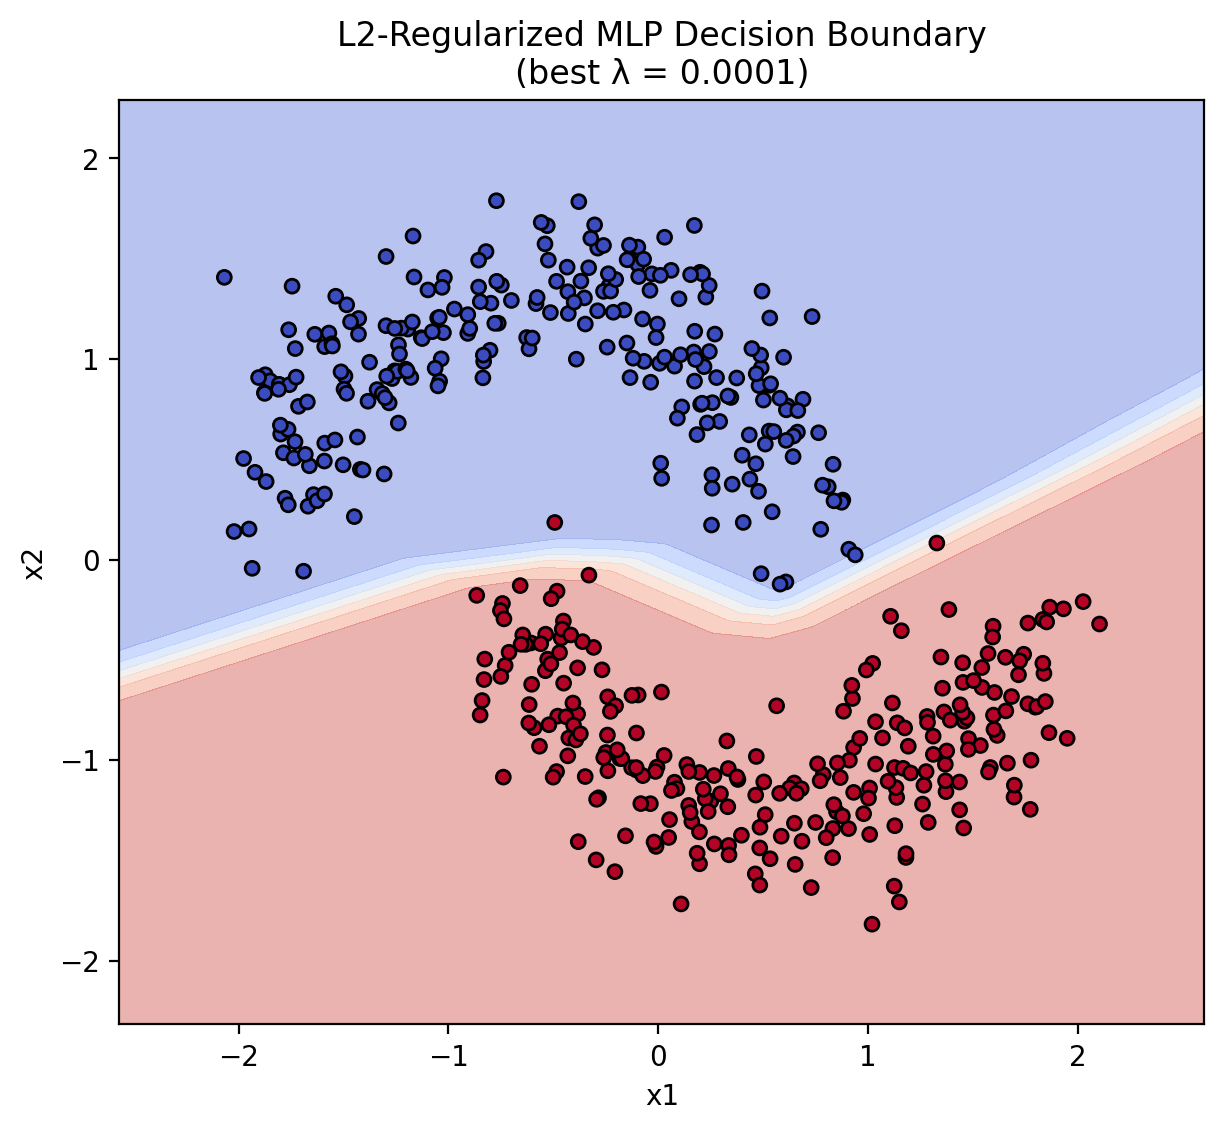

In [75]:
# ================================
# L2 REGULARIZATION GRID SEARCH
# ================================
l2_lambda_grid = [0, 1e-5, 1e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 1]

results = []

for l2_lambda in l2_lambda_grid:
    print(f"\nTraining with L2 λ = {l2_lambda}")

    # Fresh MLP model
    model = MLP(input_dim, hidden1_dim, hidden2_dim, output_dim)

    # ------------------------------
    # TRAIN FUNCTION (with early stop)
    # ------------------------------
    def train_with_l2(model, device, X_train, y_train, X_val, y_val,
                      lr=1e-3, epochs=1000, patience=50, l2_lambda=l2_lambda):

        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_lambda)
        loss_fn = nn.CrossEntropyLoss()

        X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)

        best_val_loss = float('inf')
        patience_counter = 0
        best_state = None

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            logits = model(X_train_t)
            loss = loss_fn(logits, y_train_t)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                val_logits = model(X_val_t)
                val_loss = loss_fn(val_logits, y_val_t)

            # early stopping logic
            if val_loss < best_val_loss - 1e-5:
                best_val_loss = val_loss
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

        model.load_state_dict(best_state)
        return model

    # Train model for this lambda
    trained_model = train_with_l2(model, device, X_train, y_train, X_val, y_val, l2_lambda=l2_lambda)

    # ---------------------------
    # Evaluation: validation AUROC
    # ---------------------------
    with torch.no_grad():
        val_logits = trained_model(torch.tensor(X_val, dtype=torch.float32).to(device))
        val_probs = torch.softmax(val_logits, dim=1)[:, 1].cpu().numpy()
        val_auc = roc_auc_score(y_val, val_probs)

    # ---------------------------
    # Test AUROC for noise levels
    # ---------------------------
    with torch.no_grad():
        test01_logits = trained_model(torch.tensor(X_test_01, dtype=torch.float32).to(device))
        test01_probs = torch.softmax(test01_logits, dim=1)[:, 1].cpu().numpy()
        test01_auc = roc_auc_score(y_test_01, test01_probs)

        test02_logits = trained_model(torch.tensor(X_test_02, dtype=torch.float32).to(device))
        test02_probs = torch.softmax(test02_logits, dim=1)[:, 1].cpu().numpy()
        test02_auc = roc_auc_score(y_test_02, test02_probs)

        test03_logits = trained_model(torch.tensor(X_test_03, dtype=torch.float32).to(device))
        test03_probs = torch.softmax(test03_logits, dim=1)[:, 1].cpu().numpy()
        test03_auc = roc_auc_score(y_test_03, test03_probs)

    print(f"λ={l2_lambda:.0e} | Val={val_auc:.4f} | Test02={test02_auc:.4f}")

    # ✅ Save all info including the model
    results.append({
        'lambda': l2_lambda,
        'val_auc': val_auc,
        'test01_auc': test01_auc,
        'test02_auc': test02_auc,
        'test03_auc': test03_auc,
        'model': trained_model
    })

# ================================
# ✅ Identify BEST MODEL for noise = 0.2
# ================================
best_noise02 = max(results, key=lambda x: x['test02_auc'])
best_l2_model_noise02 = best_noise02['model']
best_l2_lambda_noise02 = best_noise02['lambda']

print("\n===============================")
print(" BEST L2 MODEL FOR NOISE = 0.2")
print("===============================")
print(f"λ = {best_l2_lambda_noise02}, AUROC = {best_noise02['test02_auc']:.4f}")


# ================================
# ✅ Decision Boundary Helper
# ================================
def plot_decision_boundary(model, X, y, title):

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    model.eval()
    with torch.no_grad():
        grid_t = torch.tensor(grid, dtype=torch.float32).to(next(model.parameters()).device)
        logits = model(grid_t)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

    Z = probs.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=25, edgecolors='k')
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")


# ================================
# ✅ PLOT DECISION BOUNDARY (noise=0.2)
# ================================
plt.figure(figsize=(7, 6))
plot_decision_boundary(
    best_l2_model_noise02,
    X_test_02,
    y_test_02,
    title=f"L2-Regularized MLP Decision Boundary\n(best λ = {best_l2_lambda_noise02})"
)
plt.show()


## Polynomial features

In [80]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# -------------------------------------------------
# 1. Build the polynomial logistic regression model
# -------------------------------------------------
poly_logreg_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=400))
])

# -------------------------------------------------
# 2. Fit on TRAIN only
# -------------------------------------------------
poly_logreg_pipeline.fit(X_train, y_train)

# -------------------------------------------------
# 3. Evaluate on validation
# -------------------------------------------------
val_probs = poly_logreg_pipeline.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)
print(f"Validation AUROC = {val_auc:.4f}")

# -------------------------------------------------
# 4. Evaluate on Test Noise = 0.1
# -------------------------------------------------
test01_probs = poly_logreg_pipeline.predict_proba(X_test_01)[:, 1]
test01_auc = roc_auc_score(y_test_01, test01_probs)
print(f"Test AUROC (Noise = 0.1) = {test01_auc:.4f}")

# -------------------------------------------------
# 5. Evaluate on Test Noise = 0.2
# -------------------------------------------------
test02_probs = poly_logreg_pipeline.predict_proba(X_test_02)[:, 1]
test02_auc = roc_auc_score(y_test_02, test02_probs)
print(f"Test AUROC (Noise = 0.2) = {test02_auc:.4f}")

# -------------------------------------------------
# 6. Evaluate on Test Noise = 0.3
# -------------------------------------------------
test03_probs = poly_logreg_pipeline.predict_proba(X_test_03)[:, 1]
test03_auc = roc_auc_score(y_test_03, test03_probs)
print(f"Test AUROC (Noise = 0.3) = {test03_auc:.4f}")


Validation AUROC = 0.9996
Test AUROC (Noise = 0.1) = 1.0000
Test AUROC (Noise = 0.2) = 0.9995
Test AUROC (Noise = 0.3) = 0.9969


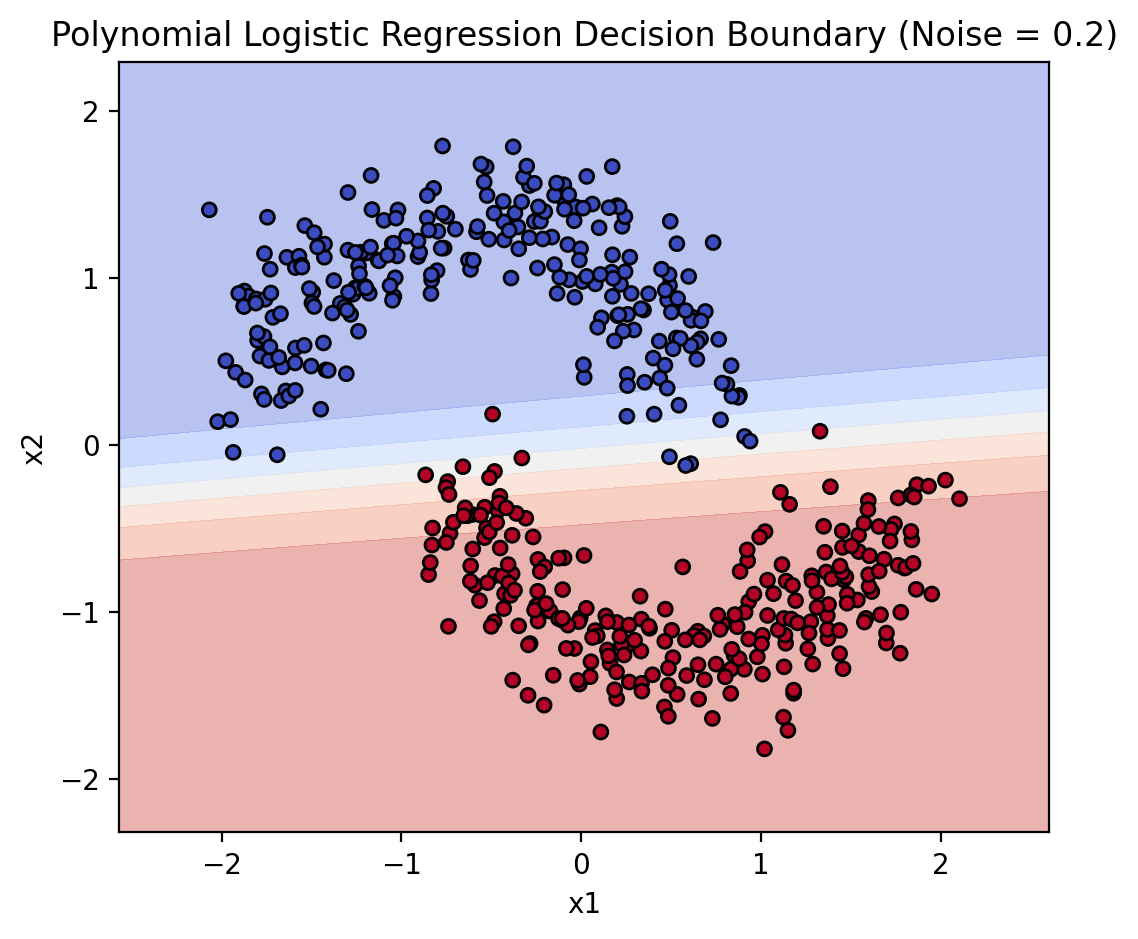

In [81]:
def plot_decision_boundary_sklearn(model, X, y, title):

    import numpy as np
    import matplotlib.pyplot as plt

    # Grid for background
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    grid = np.c_[xx.ravel(), yy.ravel()]

    # Use predict_proba from sklearn model
    probs = model.predict_proba(grid)[:, 1]
    Z = probs.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", s=25, edgecolors='k')

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")


plt.figure(figsize=(6, 5))
plot_decision_boundary_sklearn(
    poly_logreg_pipeline,
    X_test_02,
    y_test_02,
    title="Polynomial Logistic Regression Decision Boundary (Noise = 0.2)"
)
plt.show()


L1 regularization encourages sparsity by pushing many weights exactly to zero, which effectively removes some neurons or input interactions. This sparsity makes the decision boundary more piecewise and jagged, because the model relies on fewer active parameters and tends to fit sharp transitions between classes. In contrast, L2 regularization shrinks weights smoothly rather than zeroing them out, distributing influence more evenly across features. This leads to smoother, more rounded decision boundaries with a generally larger margin, because the model avoids extreme weights and becomes less sensitive to noise or sharp fluctuations in the data.